In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')


forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [3]:
# aoi
from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee(forestry.config["AOI_path"])

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

✅ AOI loaded: 1 features
   Area: 144217.67 hectares


In [4]:
use_yearly_ee = True
### load the exported gee image
asset_monthly_interpolated = 'projects/remote-sensing-476412/assets/korindo_smooth_monthly'

def annual_col_median(img_col, years):
    def per_year(year):
        start = ee.Date.fromYMD(year, 1, 1)
        # end = start.advance(1, 'year')
        end = ee.Date.fromYMD(year, 12, 31)
        return (
            img_col
            .filterDate(start, end)
            .median()
            .set('year', year)
            .set('system:time_start', end.millis())
        )
    return ee.ImageCollection(years.map(per_year))

monthly_agg = ee.ImageCollection(asset_monthly_interpolated)

# Server-side list of unique years derived from system:time_start
year_list = (
    monthly_agg
        .aggregate_array('system:time_start')         # ee.List of millis
        .map(lambda ts: ee.Date(ts).get('year'))      # convert to year
        .distinct()                                   # keep unique values
        .sort()                                       # optional
)

ee_col_year_median = annual_col_median(monthly_agg, year_list)

year_list_c = year_list.getInfo()
print(year_list_c)

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


In [5]:
ee_col_year_median.first().bandNames().getInfo()

['blue',
 'green',
 'nir',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'redE4',
 'swir1',
 'swir2']

In [6]:
## check fcd data from random points
### wait until all the fcd is processed (exported)!
# ============================================
# STEP 2: Load directly from GCS when needed
# ============================================
# Later, when you need to use the images:
def load_yearly_images_from_gcs(years, gcs_bucket='remote_sensing_saas', base_path='01-korindo/yearly_mosaic_gee'):
    """
    Load yearly images directly from GCS without ingesting to GEE.
    
    Parameters:
    -----------
    years : list[int]
        List of years to load (e.g., [2020, 2021, 2022])
    gcs_bucket : str
        GCS bucket name
    base_path : str
        Base path in bucket
    
    Returns:
    --------
    ee.ImageCollection : Collection of images loaded from GCS
    """
    images = []
    for year in years:
        gcs_path = f'gs://{gcs_bucket}/{base_path}/fcd_{year}.tif'
        img = ee.Image.loadGeoTIFF(gcs_path)
        img = img.set('year', year)
        img = img.set('system:time_start', ee.Date.fromYMD(year, 12, 31).millis())
        images.append(img)
    
    return ee.ImageCollection(images)
fcd_col = load_yearly_images_from_gcs(year_list_c)
fcd_col.first().bandNames().getInfo()

['FCD']

In [7]:
# Filter out empty images (images with 0 bands) before spectralIndices
# This prevents errors when reverse mapping tries to select bands on empty images
print("🔍 Filtering out empty images...")

def add_band_count(img):
    """Add band count as a property"""
    band_count = img.bandNames().size()
    return img.set('has_bands', band_count.gt(0))

ee_col_with_flag = ee_col_year_median.map(add_band_count)
ee_col_year_median = ee_col_with_flag.filter(ee.Filter.eq('has_bands', 1))

print(f"✅ Filtered collection size: {ee_col_year_median.size().getInfo()}")

# Now compute spectral indices
ee_col_indices = ee_col_year_median.spectralIndices(
    index=['EVI', 'GNDVI', 'NDVI','SAVI','NBR'],
    satellite_type='Sentinel',
    G=2.5,
    C1=6.0,
    C2=7.5,
    L=1.0,
    drop=False
)

🔍 Filtering out empty images...
✅ Filtered collection size: 11
🔄 Reverse mapping: Found 10 mappings, 15 bands in result


In [8]:
ee_col_year_median.first().bandNames().getInfo()

['blue',
 'green',
 'nir',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'redE4',
 'swir1',
 'swir2']

In [9]:
ee_col_indices.first().bandNames().getInfo()

['EVI',
 'GNDVI',
 'NDVI',
 'SAVI',
 'NBR',
 'blue',
 'green',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'nir',
 'redE4',
 'swir1',
 'swir2']

In [10]:
from wmts_manager import WMTSManager

wmts = WMTSManager(project_name=forestry.config['project']['name'], aoi=aoi_ee.geometry())
wmts.addLayer(ee_col_indices.first(), {'bands': ['NBR'],
   'min': 0,
   'max': 1,
 'gamma': 1.5}, 'nbr_test')

wmts.publish()


INFO:wmts_manager:WMTSManager initialized for project: forestry_carbon_project
INFO:wmts_manager:Added layer: nbr_test
INFO:wmts_manager:Generating map IDs for 1 layers...


Generating GEE Map IDs...


INFO:wmts_manager:AOI processed: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}
INFO:wmts_manager:Publishing 1 layers to WMTS...
INFO:gee_integration:GEE Integration Manager initialized:
INFO:gee_integration:  FastAPI URL: http://fastapi:8000
INFO:gee_integration:  MapStore Config: /usr/src/app/mapstore/configs/localConfig.json
INFO:gee_integration:Processing GEE analysis: forestry_carbon_project
INFO:gee_integration:🧹 Clearing duplicate projects before processing new analysis...


✅ Centroid calculated successfully with error margin 1
Calculated bbox from coordinates: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}
✅ AOI processed successfully:
   - Center: [111.90816469614359, -0.3125187262245936]
   - Area: Unknown
   - BBox: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}


INFO:cache_manager:No existing catalog entries to check for duplicates
INFO:gee_integration:✅ Duplicate clearing successful: 0 duplicates cleared, 0 unique projects kept
INFO:gee_integration:✅ Cache cleared: 0 duplicate entries, kept 0 unique projects
INFO:gee_integration:Using complex layer info for 'nbr_test': ['tile_url', 'name', 'description', 'vis_params']
INFO:gee_integration:Registering with FastAPI: forestry_carbon_project_20251203_154029
INFO:gee_integration:✅ FastAPI registration successful: MapStore catalog updated successfully
INFO:gee_integration:Creating FastAPI proxy URLs for project: forestry_carbon_project_20251203_154029
INFO:gee_integration:✅ Created 1 FastAPI proxy URLs
INFO:gee_integration:Updating MapStore WMTS: forestry_carbon_project_20251203_154029
INFO:gee_integration:🔄 Forcing comprehensive WMTS refresh...
INFO:gee_utils:Starting comprehensive WMTS refresh...
INFO:gee_utils:Clearing old WMTS services...
ERROR:gee_utils:Error clearing WMTS services: 'list' obj

{'status': 'success',
 'project_id': 'forestry_carbon_project_20251203_154029',
 'project_name': 'forestry_carbon_project',
 'fastapi_registration': {'status': 'success',
  'message': 'MapStore catalog updated successfully',
  'layers_count': 1},
 'proxy_urls_creation': {'status': 'success',
  'message': 'Created 1 proxy URLs',
  'proxy_urls': {'nbr_test': {'proxy_url': 'http://fastapi:8000/tiles/forestry_carbon_project_20251203_154029/nbr_test/{z}/{x}/{y}',
    'original_url': 'https://earthengine.googleapis.com/v1/projects/remote-sensing-476412/maps/db05a2729f7e5b62e9a94931b4b11ca6-f0c51e6dbc6534b374c0fb509a79d313/tiles/{z}/{x}/{y}',
    'layer_name': 'nbr_test',
    'description': 'NBR_TEST visualization from GEE analysis'}},
  'layers_count': 1},
 'wmts_configuration': {'status': 'success',
  'message': 'WMTS configuration updated successfully',
  'service_id': 'GEE_analysis_WMTS_layers',
  'layers_available': ['forestry_carbon_project_20251203_154029_nbr_test'],
  'layers_count': 

In [11]:
# Get years
years = ee_col_year_median.aggregate_array('year').getInfo()
print(f"Years: {years}")

Years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


In [12]:
# Get years
years = fcd_col.aggregate_array('year').getInfo()
print(f"Years: {years}")

Years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


In [13]:
## MERGING TWO IMAGE COLLECTIONS
# Merge with FCD - ensure clean images without swir2 references for xee compatibility
def merge_with_fcd(img):
    """Merge spectral indices with FCD, creating clean images without problematic references"""
    # Get year for matching
    year = img.get('year')
    
    # Select only the spectral indices we need (this creates a new image and breaks computation graph)
    # Force select to ensure we only have the bands we want
    si_selected = img.select(['EVI', 'GNDVI', 'NDVI', 'SAVI', 'NBR'])
    
    # Get matching FCD image - use a simpler approach that avoids ee.Algorithms.If
    # Filter and get first, with a fallback
    fcd_filtered = fcd_col.filter(ee.Filter.eq('year', year))
    
    # Use a conditional that's more explicit
    fcd_exists = fcd_filtered.size()
    fcd_img = ee.Image(
        ee.Algorithms.If(
            fcd_exists.gt(0),
            fcd_filtered.first().select('FCD'),
            ee.Image.constant(0).rename('FCD')
        )
    )
    
    # Merge - ensure both images have bands
    merged = si_selected.addBands(fcd_img)
    
    # Verify the merged image has bands before returning
    # Create a completely new image with explicit band selection to break any computation graph
    final_bands = ['EVI', 'GNDVI', 'NDVI', 'SAVI', 'NBR', 'FCD']
    result = merged.select(final_bands)
    
    # Only set essential properties (avoid copying system:band_names or other problematic properties)
    result = result.set('year', year).set('system:time_start', img.get('system:time_start'))
    
    return result

fcd_col_merged = ee_col_indices.map(merge_with_fcd)

In [14]:
fcd_col_merged.first().bandNames().getInfo()

['EVI', 'GNDVI', 'NDVI', 'SAVI', 'NBR', 'FCD']

In [15]:
from wmts_manager import WMTSManager

wmts = WMTSManager(project_name=forestry.config['project']['name'], aoi=aoi_ee.geometry())
wmts.addLayer(fcd_col_merged.first(), {'bands': ['FCD'],
   'min': 0,
   'max': 100,
 'gamma': 1.5}, 'fcd_test')

wmts.addLayer(fcd_col_merged.first(), {'bands': ['NBR'],
   'min': 0,
   'max': 1,
 'gamma': 1.5}, 'nbr_test_fcd')


wmts.publish()


INFO:wmts_manager:WMTSManager initialized for project: forestry_carbon_project
INFO:wmts_manager:Added layer: fcd_test
INFO:wmts_manager:Added layer: nbr_test_fcd
INFO:wmts_manager:Generating map IDs for 2 layers...


Generating GEE Map IDs...


INFO:wmts_manager:AOI processed: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}
INFO:wmts_manager:Publishing 2 layers to WMTS...
INFO:gee_integration:GEE Integration Manager initialized:
INFO:gee_integration:  FastAPI URL: http://fastapi:8000
INFO:gee_integration:  MapStore Config: /usr/src/app/mapstore/configs/localConfig.json
INFO:gee_integration:Processing GEE analysis: forestry_carbon_project
INFO:gee_integration:🧹 Clearing duplicate projects before processing new analysis...
INFO:cache_manager:No existing catalog entries to check for duplicates
INFO:gee_integration:✅ Duplicate clearing successful: 0 duplicates cleared, 0 unique projects kept
INFO:gee_integration:✅ Cache cleared: 0 duplicate entries, kept 0 unique projects
INFO:gee_integration:Using complex layer info for 'fcd_test': ['tile_url', 'name', 'description', 'vis_params']
INFO:gee_integration:Using complex layer info for 'nbr_test_fcd': ['tile_url', 'name', 'd

✅ Centroid calculated successfully with error margin 1
Calculated bbox from coordinates: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}
✅ AOI processed successfully:
   - Center: [111.90816469614359, -0.3125187262245936]
   - Area: Unknown
   - BBox: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}


ERROR:gee_utils:Error clearing WMTS services: 'list' object has no attribute 'get'
INFO:gee_utils:Refreshing WMTS capabilities...
INFO:gee_utils:WMTS capabilities refreshed successfully
INFO:gee_utils:Updating MapStore WMTS service...
INFO:gee_utils:Successfully updated MapStore WMTS service: gee_analysis_wmts
INFO:gee_utils:Getting current WMTS layers...
INFO:gee_utils:Comprehensive WMTS refresh completed successfully - Found 2 layers
INFO:gee_integration:✅ MapStore WMTS configuration updated
INFO:gee_integration:   New layers found: 2
INFO:wmts_manager:WMTS publishing completed: success


{'status': 'success',
 'project_id': 'forestry_carbon_project_20251203_154033',
 'project_name': 'forestry_carbon_project',
 'fastapi_registration': {'status': 'success',
  'message': 'MapStore catalog updated successfully',
  'layers_count': 2},
 'proxy_urls_creation': {'status': 'success',
  'message': 'Created 2 proxy URLs',
  'proxy_urls': {'fcd_test': {'proxy_url': 'http://fastapi:8000/tiles/forestry_carbon_project_20251203_154033/fcd_test/{z}/{x}/{y}',
    'original_url': 'https://earthengine.googleapis.com/v1/projects/remote-sensing-476412/maps/b0cc49fa450e60d17d78ef259be8b377-248c07a6ae17b46d608a1019cc3bac75/tiles/{z}/{x}/{y}',
    'layer_name': 'fcd_test',
    'description': 'FCD_TEST visualization from GEE analysis'},
   'nbr_test_fcd': {'proxy_url': 'http://fastapi:8000/tiles/forestry_carbon_project_20251203_154033/nbr_test_fcd/{z}/{x}/{y}',
    'original_url': 'https://earthengine.googleapis.com/v1/projects/remote-sensing-476412/maps/ed53b8cb615690affc2a3f363b812e25-8336bd0

In [16]:
fcd_col_merged.first().get('system:band_names').getInfo()

['EVI', 'GNDVI', 'NDVI', 'SAVI', 'NBR', 'FCD']

In [17]:
### convert the FCD image collection to the xee
# Now using UTM CRS with meter scale - they match!
import os

## path to the zarr file - GCS
gcs_dir = os.getenv('GCS_ZARR_DIR')

import xee
import numpy as np
import xarray as xr

print("🔄 Converting Earth Engine ImageCollection to xarray Dataset...")
print(f"   CRS: {'EPSG:32749'} (UTM, meters)")
print(f"   Scale: {10}m")
print("   This may take a moment as xee accesses the data from Earth Engine...")

# Reproject aoi_ee to UTM first (for region parameter)
# Use aoi_ee_utm already created in cell 11 (UTM geometry)

from shapely.geometry import box

utm_crs = forestry.config['output_crs']
utm_epsg = int(utm_crs.split(':')[1])
pixel_scale = forestry.config['resolution_satellite']

# bbox = box(*aoi_gpd_utm.total_bounds)
# Get UTM bounds from GeoDataFrame and validate
aoi_gpd_utm = aoi_gpd.to_crs(forestry.config['output_crs'])
bounds_utm = aoi_gpd_utm.total_bounds  # [minx, miny, maxx, maxy]

# Validate bounds are not NaN
if np.any(np.isnan(bounds_utm)):
    raise ValueError(f"Bounds contain NaN values: {bounds_utm}")

xmin, ymin, xmax, ymax = bounds_utm
print(f"UTM Bounds: xmin={xmin:.2f}, ymin={ymin:.2f}, xmax={xmax:.2f}, ymax={ymax:.2f}")
print(f"UTM Bounds span: {(xmax-xmin):.2f}m x {(ymax-ymin):.2f}m")

# Create rectangle geometry in UTM CRS
# rectangle = ee.Geometry.Rectangle(xmin, ymin, xmax, ymax)

## SETUP FOR FCD TO XARRAY
ic = fcd_col_merged

# Method 2: Use transformed geometry directly (more reliable)
# Create UTM geometry from aoi_ee
aoi_ee_utm_geom = aoi_ee.geometry().transform(
    f'EPSG:{utm_epsg}',
    maxError=1
)

ds = xr.open_dataset(
    ic,
    engine='ee',
    crs=utm_crs,
    scale=pixel_scale,
    geometry=aoi_ee_utm_geom # significanly faster to clip with geometry
)
print("✅ Successfully created dataset using transformed geometry")

if 'X' in ds.dims and 'Y' in ds.dims:
    print("Renaming dimensions from X,Y to x,y")
    ds = ds.rename({'X': 'x', 'Y': 'y'})

print(f"\n📦 Dataset created: {type(ds)}")
print(f"   CRS: {utm_crs} (UTM, meters)")
print(f"   Scale: {pixel_scale}m")
print(f"   Dimensions: {dict(ds.dims)}")
print(f"   Data variables: {list(ds.data_vars.keys())}")
print(f"   Coordinates: {list(ds.coords.keys())}")

🔄 Converting Earth Engine ImageCollection to xarray Dataset...
   CRS: EPSG:32749 (UTM, meters)
   Scale: 10m
   This may take a moment as xee accesses the data from Earth Engine...
UTM Bounds: xmin=578614.54, ymin=9949385.44, xmax=623504.21, ymax=9981518.44
UTM Bounds span: 44889.68m x 32133.00m
✅ Successfully created dataset using transformed geometry
Renaming dimensions from X,Y to x,y

📦 Dataset created: <class 'xarray.core.dataset.Dataset'>
   CRS: EPSG:32749 (UTM, meters)
   Scale: 10m
   Dimensions: {'time': 11, 'x': 4489, 'y': 3213}
   Data variables: ['EVI', 'GNDVI', 'NDVI', 'SAVI', 'NBR', 'FCD']
   Coordinates: ['time', 'x', 'y']


/tmp/ipykernel_11443/1880987262.py:68: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")


In [18]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 11, x: 4489, y: 3213)
Coordinates:
  * time     (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI      (time, x, y) float32 635MB ...
    GNDVI    (time, x, y) float32 635MB ...
    NDVI     (time, x, y) float32 635MB ...
    SAVI     (time, x, y) float32 635MB ...
    NBR      (time, x, y) float32 635MB ...
    FCD      (time, x, y) float32 635MB ...
Attributes:
    crs:      EPSG:32749

In [19]:
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr
import os

use_exported_ds = True

# Determine zarr path
zarr_path = os.getenv('GCS_ZARR_DIR', '')
if zarr_path:
    if not zarr_path.startswith('gs://'):
        zarr_path = f"gs://{zarr_path}/ds_resampled_fcd_with_indice_merged.zarr"
    else:
        zarr_path = f"{zarr_path}/ds_resampled_fcd_with_indice_merged.zarr"
    storage = 'gcs'
    # print(f"   Saving to GCS: {zarr_path}")
else:
    zarr_path = os.path.join(os.getcwd(), 'data', 'ds_resampled_fcd_with_indice_merged.zarr')
    storage = 'local'
    print(f"   Saving to local: {zarr_path}")

if use_exported_ds != True:

    # Rename dimensions (X, Y -> x, y)
    # ds_resampled = ds.rename({'X': 'x', 'Y': 'y'}) # no need to do it twice from above
    ds_resampled = ds

    # Save to zarr
    chunk_sizes = {'time': 40, 'x': 1024, 'y': 1024}
    print("   Saving dataset to zarr...")
    save_dataset_efficient_zarr(
        ds_resampled,
        zarr_path,
        chunk_sizes=chunk_sizes,
        compression='lz4',
        compression_level=1,
        overwrite=True,
        storage=storage,
        gee_compatible=True
    )
    print(f"✅ Dataset saved to zarr")

    # Load from zarr to avoid GEE server-side errors
    print(f"\n   Loading from: {zarr_path}")
else:
    ds_resampled = load_dataset_zarr(zarr_path, storage=storage)

print(f"✅ Dataset loaded from zarr")
print(f"   Dataset: {dict(ds_resampled.sizes)}")
print(f"   Variables: {list(ds_resampled.data_vars)}")
print(f"\n✅ ds_resampled ready for tsfresh processing")

INFO:forestry_carbon_arr.utils.zarr_utils:Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled_fcd_with_indice_merged.zarr


📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled_fcd_with_indice_merged.zarr
✅ Dataset loaded: {'time': 11, 'x': 4489, 'y': 3213}
✅ Dataset loaded from zarr
   Dataset: {'time': 11, 'x': 4489, 'y': 3213}
   Variables: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI']

✅ ds_resampled ready for tsfresh processing


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


In [20]:
ds_resampled

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 11, x: 4489, y: 3213)
Coordinates:
  * time     (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI      (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    FCD      (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    GNDVI    (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    NBR      (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    NDVI     (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
    SAVI     (time, x, y) float32 635MB dask.array<chunksize=(11, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [21]:
gcs_path_df_long = f'gs://{os.getenv("GCS_BUCKET_PATH")}/01-korindo/sample_tsfresh/20251203_df_long_yearly.parquet'
training_gdf = gpd.read_parquet(gcs_path_df_long, filesystem=fs)

# # Check and set CRS if missing (parquet files sometimes lose CRS info)
# if training_gdf.crs is None:
#     print("⚠️  Training data has no CRS. Assuming EPSG:4326 (WGS84) and converting...")
#     training_gdf = training_gdf.set_crs('EPSG:4326', allow_override=True)
# else:
#     print(f"✓ Training data CRS: {training_gdf.crs}")

# # Convert to output CRS
# print(f"Converting to {forestry.config['output_crs']}...")
# training_gdf = training_gdf.to_crs(forestry.config['output_crs'])
# print(f"✓ Training data converted to {training_gdf.crs}")
training_gdf_yearly = training_gdf.copy()

# training_gdf

In [22]:
training_gdf_yearly

,layer,time_period,type,date,geometry,year
0,sample_2,t_201612,0,2016-12-31,"POLYGON ((592439.970 9950624.446, 592472.225 9...",2016
0,sample_2,t_201612,0,2016-12-31,"POLYGON ((590373.639 9951237.807, 590370.392 9...",2016
1,sample_2,t_201612,0,2016-12-31,"POLYGON ((591963.540 9951127.666, 591985.528 9...",2016
2,sample_2,t_201612,0,2016-12-31,"POLYGON ((592062.841 9950226.187, 592071.853 9...",2016
2,sample_2,t_201612,0,2016-12-31,"POLYGON ((591918.846 9950233.674, 591917.704 9...",2016
...,...,...,...,...,...,...
1298,sample_8,t_202509,0,2025-12-31,"POLYGON ((584339.466 9978699.127, 584333.952 9...",2025
1299,sample_8,t_202509,1,2025-12-31,"POLYGON ((584051.894 9978044.775, 584075.402 9...",2025
1299,sample_8,t_202509,1,2025-12-31,"POLYGON ((584682.580 9978585.104, 584715.047 9...",2025
1299,sample_8,t_202509,1,2025-12-31,"POLYGON ((584349.197 9978701.060, 584349.846 9...",2025


In [23]:
ground_truth_path = gcs_path_df_long

ds_gt_list = forestry.prepare_tsfresh_with_ground_truth(
    ds_resampled=ds_resampled,  # From Step 1
    ground_truth_path=ground_truth_path,  # GCS or local path to parquet
    buffer_pixels=5,  # Buffer around sample bboxes
    save_to_zarr=False,  # Save to zarr for efficient access
    zarr_path=None,  # Auto-detects from GCS_ZARR_DIR env var
    overwrite_zarr=False,  # Don't overwrite if exists
    storage='auto'
)

print(f"\n✅ Prepared {len(ds_gt_list)} sample datasets")
for i, ds_gt in enumerate(ds_gt_list):
    plot_id = ds_gt.coords['plot_id'].values[0] if 'plot_id' in ds_gt.coords else f'sample_{i+1}'
    print(f"   {plot_id}: {dict(ds_gt.sizes)}")
    print(f"      Variables: {list(ds_gt.data_vars)}")

INFO:forestry_carbon_arr.core.main.ForestryCarbonARR:============================================================
INFO:forestry_carbon_arr.core.main.ForestryCarbonARR:Preparing tsfresh data with ground truth
INFO:forestry_carbon_arr.core.main.ForestryCarbonARR:============================================================
INFO:forestry_carbon_arr.utils.tsfresh_utils:Loading ground truth from GCS: gs://remote_sensing_saas/01-korindo/sample_tsfresh/20251203_df_long_yearly.parquet
INFO:forestry_carbon_arr.utils.tsfresh_utils:Loaded 3980 training polygons
INFO:forestry_carbon_arr.utils.tsfresh_utils:Columns: ['layer', 'time_period', 'type', 'date', 'geometry', 'year']
INFO:forestry_carbon_arr.utils.tsfresh_utils:Unique layers: ['sample_2' 'sample_4' 'sample_6' 'sample_5' 'sample_7' 'sample_1'
 'sample_3' 'sample_8']
INFO:forestry_carbon_arr.core.main.ForestryCarbonARR:Preparing tsfresh data with ground truth labels...
INFO:forestry_carbon_arr.utils.tsfresh_utils:Standardizing dataset to STAC


✅ Prepared 8 sample datasets
   sample_2: {'time': 11, 'x': 323, 'y': 212, 'plot_id': 1}
      Variables: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI', 'ground_truth', 'gt_valid']
   sample_4: {'time': 11, 'x': 319, 'y': 226, 'plot_id': 1}
      Variables: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI', 'ground_truth', 'gt_valid']
   sample_6: {'time': 11, 'x': 282, 'y': 176, 'plot_id': 1}
      Variables: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI', 'ground_truth', 'gt_valid']
   sample_5: {'time': 11, 'x': 341, 'y': 204, 'plot_id': 1}
      Variables: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI', 'ground_truth', 'gt_valid']
   sample_7: {'time': 11, 'x': 511, 'y': 381, 'plot_id': 1}
      Variables: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI', 'ground_truth', 'gt_valid']
   sample_1: {'time': 11, 'x': 232, 'y': 141, 'plot_id': 1}
      Variables: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI', 'ground_truth', 'gt_valid']
   sample_3: {'time': 11, 'x': 324, 'y': 251, 'plot_id': 1

In [24]:
ds_gt_list[2]

<xarray.Dataset> Size: 20MB
Dimensions:       (time: 11, x: 282, y: 176, plot_id: 1)
Coordinates:
  * time          (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * x             (x) float64 2kB 6.149e+05 6.149e+05 ... 6.177e+05 6.177e+05
  * y             (y) float64 1kB 9.978e+06 9.978e+06 ... 9.977e+06 9.977e+06
  * plot_id       (plot_id) object 8B 'sample_6'
    epsg          int64 8B 32749
Data variables:
    EVI           (plot_id, time, x, y) float32 2MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    FCD           (plot_id, time, x, y) float32 2MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    GNDVI         (plot_id, time, x, y) float32 2MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    NBR           (plot_id, time, x, y) float32 2MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    NDVI          (plot_id, time, x, y) float32 2MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    SAVI          (plot_id, time, x, y) float32 2MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    ground_truth  (plot_id, time, y, x) float32 2MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    gt_valid      (plot_id, time, y, x) float64 4MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [25]:
import pandas as pd

# Inspect first sample dataset
if len(ds_gt_list) > 0:
    ds_gt = ds_gt_list[0]
    plot_id = ds_gt.coords['plot_id'].values[0] if 'plot_id' in ds_gt.coords else 'sample_1'
    
    print(f"Sample: {plot_id}")
    print(f"Dimensions: {dict(ds_gt.sizes)}")
    print(f"Variables: {list(ds_gt.data_vars)}")
    print(f"\nTime range: {pd.to_datetime(ds_gt.time.min().values)} to {pd.to_datetime(ds_gt.time.max().values)}")
    
    # Check ground truth statistics
    if 'ground_truth' in ds_gt.data_vars:
        gt_values = ds_gt['ground_truth'].values.flatten()
        n_total = len(gt_values)
        n_nan = np.isnan(gt_values).sum()
        n_zeros = (gt_values == 0).sum()
        n_ones = (gt_values == 1).sum()
        
        print(f"\nGround Truth Statistics:")
        print(f"  Total pixels: {n_total:,}")
        print(f"  NaN (no label): {n_nan:,} ({100*n_nan/n_total:.1f}%)")
        print(f"  0 (non-tree): {n_zeros:,} ({100*n_zeros/n_total:.1f}%)")
        print(f"  1 (tree): {n_ones:,} ({100*n_ones/n_total:.1f}%)")
    
    # Show dataset structure
    print(f"\nDataset structure:")
    print(ds_gt)


Sample: sample_2
Dimensions: {'time': 11, 'x': 323, 'y': 212, 'plot_id': 1}
Variables: ['EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI', 'ground_truth', 'gt_valid']

Time range: 2015-12-31 00:00:00 to 2025-12-31 00:00:00

Ground Truth Statistics:
  Total pixels: 753,236
  NaN (no label): 250,436 (33.2%)
  0 (non-tree): 183,373 (24.3%)
  1 (tree): 319,427 (42.4%)

Dataset structure:
<xarray.Dataset> Size: 27MB
Dimensions:       (time: 11, x: 323, y: 212, plot_id: 1)
Coordinates:
  * time          (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * x             (x) float64 3kB 5.898e+05 5.898e+05 ... 5.93e+05 5.93e+05
  * y             (y) float64 2kB 9.952e+06 9.952e+06 ... 9.95e+06 9.95e+06
  * plot_id       (plot_id) object 8B 'sample_2'
    epsg          int64 8B 32749
Data variables:
    EVI           (plot_id, time, x, y) float32 3MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    FCD           (plot_id, time, x, y) float32 3MB dask.array<chunksize=(1, 11,

VISUALIZING GROUND TRUTH: sample_3 at 2025-12-31
Found dataset with plot_id: sample_3


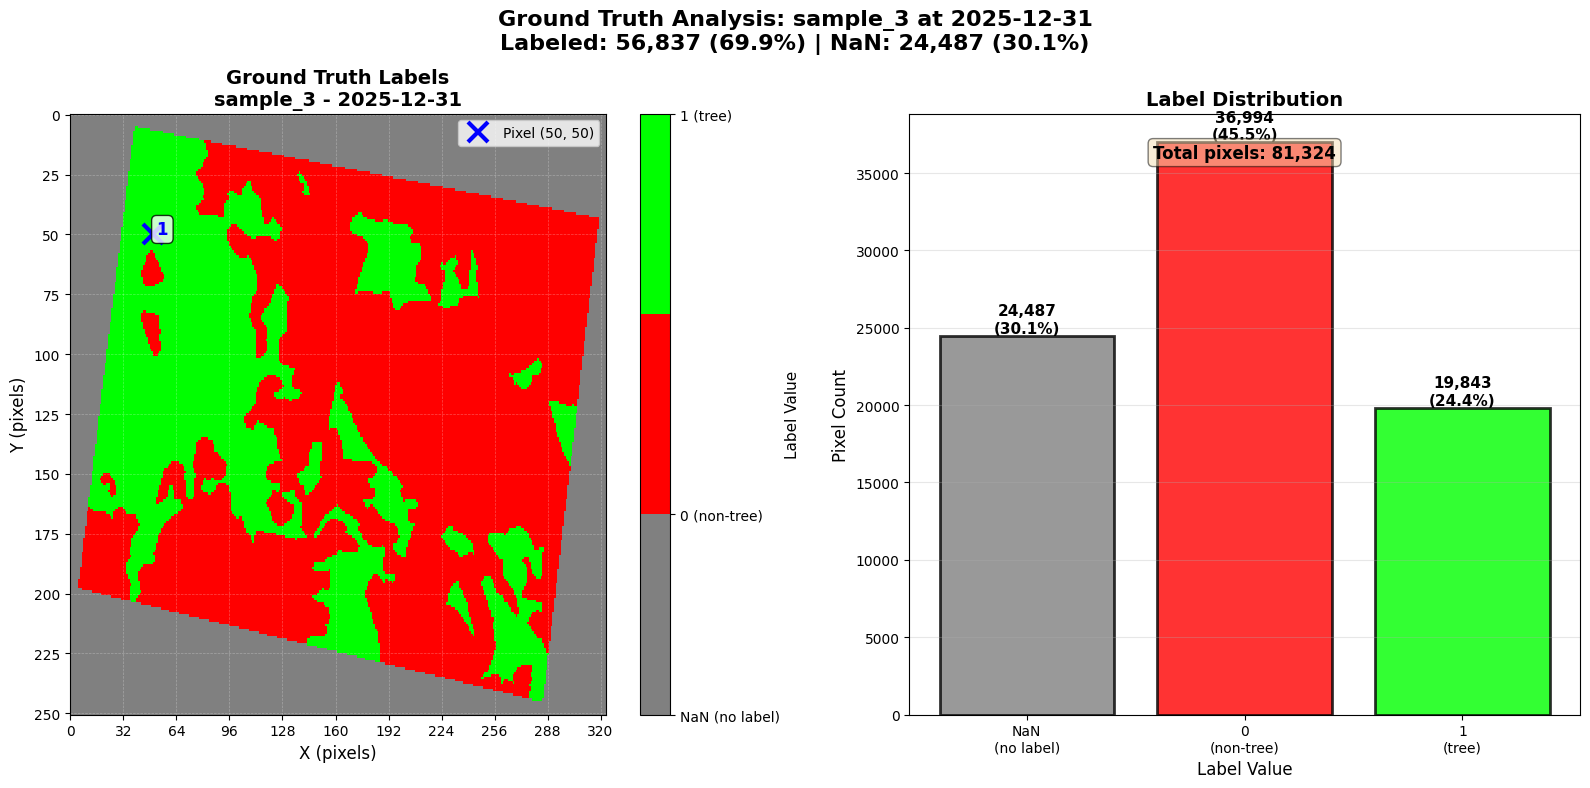


STATISTICS:
Total pixels: 81,324
  NaN (no label): 24,487 (30.11%)
  0 (non-tree):   36,994 (45.49%)
  1 (tree):       19,843 (24.40%)

Labeled pixels: 56,837 (69.89%)


In [26]:
# ============================================================================
# VISUALIZE: Ground Truth Labels Only (1, 0, NaN)
# ============================================================================
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

plot_name = 'sample_3'
time_str = '2025-12-31'

print("=" * 60)
print(f"VISUALIZING GROUND TRUTH: {plot_name} at {time_str}")
print("=" * 60)

# Find the dataset with matching plot_id
ds = None
for ds_candidate in ds_gt_list:
    if 'plot_id' in ds_candidate.coords:
        plot_id_value = ds_candidate.coords['plot_id'].values[0]
        if plot_id_value == plot_name:
            ds = ds_candidate
            break

if ds is None:
    raise ValueError(f"Could not find dataset with plot_id='{plot_name}'. Available plot_ids: {[ds.coords['plot_id'].values[0] if 'plot_id' in ds.coords else 'unknown' for ds in ds_gt_list]}")

print(f"Found dataset with plot_id: {ds.coords['plot_id'].values[0]}")


# Get ground truth slice
gt_slice = ds['ground_truth'].sel(plot_id=plot_name, time=time_str)

# Prepare data for visualization
gt_values = gt_slice.values.copy()
# Map: NaN -> -1, 0 -> 0, 1 -> 2 (for colormap indexing)
gt_plot = np.full_like(gt_values, -1, dtype=float)
gt_plot[gt_values == 0] = 0
gt_plot[gt_values == 1] = 2
gt_plot[np.isnan(gt_values)] = -1

# Count values
values = gt_values.flatten()
n_nan = np.isnan(values).sum()
n_zeros = (values == 0).sum()
n_ones = (values == 1).sum()
n_total = len(values)

# Create custom colormap: NaN=gray, 0=red, 1=green
colors = ['#808080', '#FF0000', '#00FF00']  # gray, red, green
cmap_custom = ListedColormap(colors)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Ground Truth Labels
ax1 = axes[0]
im1 = ax1.imshow(gt_plot, cmap=cmap_custom, vmin=-1, vmax=2, aspect='auto', interpolation='nearest')
ax1.set_title(f'Ground Truth Labels\n{plot_name} - {time_str}', fontsize=14, fontweight='bold')
ax1.set_xlabel('X (pixels)', fontsize=12)
ax1.set_ylabel('Y (pixels)', fontsize=12)

# Add grid
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='white')
ax1.set_xticks(range(0, gt_slice.shape[1], max(1, gt_slice.shape[1]//10)))
ax1.set_yticks(range(0, gt_slice.shape[0], max(1, gt_slice.shape[0]//10)))

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1, ticks=[-1, 0, 2])
cbar1.set_ticklabels(['NaN (no label)', '0 (non-tree)', '1 (tree)'])
cbar1.set_label('Label Value', fontsize=11)

# Mark specific pixel if checking
check_x, check_y = 50, 50
if 0 <= check_x < gt_slice.shape[1] and 0 <= check_y < gt_slice.shape[0]:
    ax1.plot(check_x, check_y, 'bx', markersize=15, markeredgewidth=3, 
             label=f'Pixel ({check_x}, {check_y})')
    pixel_val = gt_values[check_y, check_x]
    if np.isnan(pixel_val):
        label_text = 'NaN'
    else:
        label_text = f'{int(pixel_val)}'
    ax1.text(check_x + 2, check_y, label_text, color='blue', 
             fontsize=12, fontweight='bold', bbox=dict(boxstyle='round', 
             facecolor='white', alpha=0.8))
    ax1.legend(loc='upper right', fontsize=10)

# Plot 2: Statistics Bar Chart
ax2 = axes[1]
categories = ['NaN\n(no label)', '0\n(non-tree)', '1\n(tree)']
counts = [n_nan, n_zeros, n_ones]
colors_bar = ['#808080', '#FF0000', '#00FF00']
percentages = [100 * c / n_total for c in counts]

bars = ax2.bar(categories, counts, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Pixel Count', fontsize=12)
ax2.set_xlabel('Label Value', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, pct, count in zip(bars, percentages, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add total count text
ax2.text(0.5, 0.95, f'Total pixels: {n_total:,}',
         transform=ax2.transAxes, ha='center', va='top',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Ground Truth Analysis: {plot_name} at {time_str}\n'
             f'Labeled: {n_zeros + n_ones:,} ({100*(n_zeros+n_ones)/n_total:.1f}%) | '
             f'NaN: {n_nan:,} ({100*n_nan/n_total:.1f}%)',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n" + "=" * 60)
print("STATISTICS:")
print("=" * 60)
print(f"Total pixels: {n_total:,}")
print(f"  NaN (no label): {n_nan:,} ({100*n_nan/n_total:.2f}%)")
print(f"  0 (non-tree):   {n_zeros:,} ({100*n_zeros/n_total:.2f}%)")
print(f"  1 (tree):       {n_ones:,} ({100*n_ones/n_total:.2f}%)")
print(f"\nLabeled pixels: {n_zeros + n_ones:,} ({100*(n_zeros+n_ones)/n_total:.2f}%)")


In [27]:
## check only gt_valid
# Quick random sampling
plot_name = 'sample_2'
time_str = '2025-12-31'
n_samples = 10

# Find the dataset with matching plot_id
ds = None
for ds_candidate in ds_gt_list:
    if 'plot_id' in ds_candidate.coords:
        plot_id_value = ds_candidate.coords['plot_id'].values[0]
        if plot_id_value == plot_name:
            ds = ds_candidate
            break

if ds is None:
    raise ValueError(f"Could not find dataset with plot_id='{plot_name}'. Available plot_ids: {[ds.coords['plot_id'].values[0] if 'plot_id' in ds.coords else 'unknown' for ds in ds_gt_list]}")

print(f"Found dataset with plot_id: {ds.coords['plot_id'].values[0]}")


# Get valid pixels
gt_slice = ds['ground_truth'].sel(plot_id=plot_name, time=time_str)
valid_mask = ~np.isnan(gt_slice.values)
y_indices, x_indices = np.where(valid_mask)

# Random sample
random_idx = np.random.choice(len(y_indices), size=min(n_samples, len(y_indices)), replace=False)
sampled_y = y_indices[random_idx]
sampled_x = x_indices[random_idx]
sampled_gt = gt_slice.values[sampled_y, sampled_x]

# Get coordinates
x_coords = gt_slice.x.values[sampled_x]
y_coords = gt_slice.y.values[sampled_y]

# Results
for i, (x, y, gt, xc, yc) in enumerate(zip(sampled_x, sampled_y, sampled_gt, x_coords, y_coords)):
    label = 'tree' if gt == 1 else 'non-tree'
    print(f"Pixel {i+1}: ({x}, {y}) at ({xc:.2f}, {yc:.2f}) → GT={int(gt)} ({label})")


Found dataset with plot_id: sample_2
Pixel 1: (130, 54) at (591079.54, 9951406.12) → GT=1 (tree)
Pixel 2: (205, 92) at (591829.54, 9951026.12) → GT=0 (non-tree)
Pixel 3: (194, 80) at (591719.54, 9951146.12) → GT=1 (tree)
Pixel 4: (143, 175) at (591209.54, 9950196.12) → GT=1 (tree)
Pixel 5: (182, 144) at (591599.54, 9950506.12) → GT=1 (tree)
Pixel 6: (246, 160) at (592239.54, 9950346.12) → GT=0 (non-tree)
Pixel 7: (194, 168) at (591719.54, 9950266.12) → GT=1 (tree)
Pixel 8: (250, 43) at (592279.54, 9951516.12) → GT=1 (tree)
Pixel 9: (309, 121) at (592869.54, 9950736.12) → GT=1 (tree)
Pixel 10: (273, 183) at (592509.54, 9950116.12) → GT=0 (non-tree)


Plot ID: sample_2
Plot ID: sample_4
Plot ID: sample_6
Plot ID: sample_5
Plot ID: sample_7
Plot ID: sample_1
Plot ID: sample_3
Plot ID: sample_8
RANDOM PIXEL TIMESERIES PLOTS:
Bands: ['FCD']

Processing: sample_2
  Selected pixel: (y=48, x=291)
  Coordinates: (592689.54, 9951466.12)
    Ground truth markers: 0 trees (green), 0 non-trees (red)
  Timeseries: 11 time points, 0 labeled (0 tree, 0 non-tree)

Processing: sample_4
  Selected pixel: (y=2, x=222)
  Coordinates: (595869.54, 9974386.12)
    Ground truth markers: 0 trees (green), 0 non-trees (red)
  Timeseries: 11 time points, 0 labeled (0 tree, 0 non-tree)

Processing: sample_6
  Selected pixel: (y=135, x=88)
  Coordinates: (615769.54, 9977146.12)
    Ground truth markers: 0 trees (green), 10 non-trees (red)
  Timeseries: 11 time points, 10 labeled (0 tree, 10 non-tree)

Processing: sample_5
  Selected pixel: (y=160, x=326)
  Coordinates: (612899.54, 9965596.12)
    Ground truth markers: 0 trees (green), 10 non-trees (red)
  Times

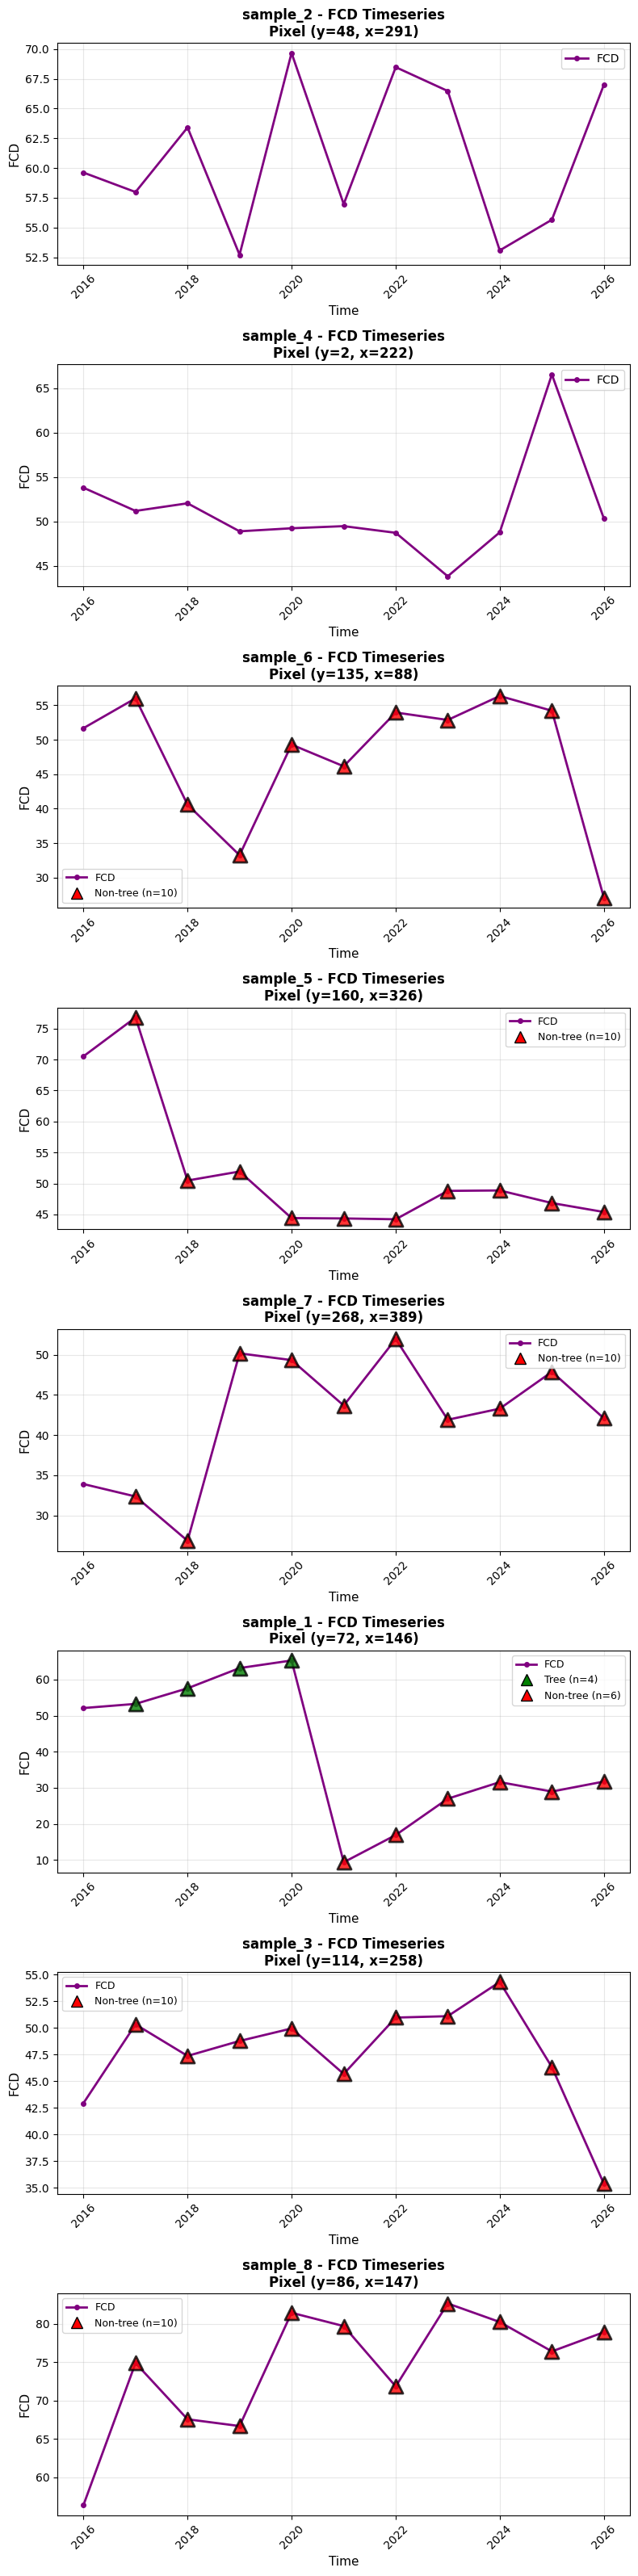


TIMESERIES PLOTS COMPLETE
Legend: Green triangle = tree (1), Red triangle = non-tree (0)


In [28]:
# ============================================================================
# MODULAR FUNCTION: Plot Random Pixel Timeseries for Specified Bands
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_random_pixel_timeseries(ds_gt_list, band_list, figsize_per_plot=(8, 4), random_seed=None):
    """
    Plot timeseries for randomly selected valid pixels across multiple datasets and bands.
    
    Parameters
    ----------
    ds_gt_list : list of xarray.Dataset
        List of datasets, one per plot/sample
    band_list : list of str
        List of band names to plot (e.g., ['FCD'], ['NDVI', 'EVI'], ['FCD', 'NDVI', 'EVI'])
    figsize_per_plot : tuple, optional
        Figure size per subplot (width, height). Default (8, 4)
    random_seed : int, optional
        Random seed for reproducibility. Default None
    
    Returns
    -------
    None
        Displays matplotlib figure
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Validate bands exist in datasets
    available_bands = set()
    for ds in ds_gt_list:
        available_bands.update(ds.data_vars.keys())
    
    missing_bands = set(band_list) - available_bands
    if missing_bands:
        raise ValueError(f"Bands not found in datasets: {missing_bands}. Available bands: {sorted(available_bands)}")
    
    print("=" * 60)
    print("RANDOM PIXEL TIMESERIES PLOTS:")
    print(f"Bands: {band_list}")
    print("=" * 60)
    
    n_datasets = len(ds_gt_list)
    n_bands = len(band_list)
    
    # Create subplots: n_datasets rows, n_bands columns
    fig, axes = plt.subplots(n_datasets, n_bands, 
                             figsize=(figsize_per_plot[0] * n_bands, figsize_per_plot[1] * n_datasets))
    
    # Handle single dataset or single band case
    if n_datasets == 1:
        axes = axes.reshape(1, -1) if n_bands > 1 else axes.reshape(1, 1)
    elif n_bands == 1:
        axes = axes.reshape(-1, 1)
    
    # Color and marker styles for different bands
    band_styles = {
        'FCD': {'color': 'purple', 'marker': 'o', 'linestyle': '-'},
        'NDVI': {'color': 'green', 'marker': 'o', 'linestyle': '-'},
        'EVI': {'color': 'blue', 'marker': 's', 'linestyle': '-'},
    }
    # Default style for unknown bands
    default_style = {'color': 'black', 'marker': 'o', 'linestyle': '-'}
    
    for idx, ds in enumerate(ds_gt_list):
        plot_id = ds.plot_id.item() if hasattr(ds, 'plot_id') else ds.coords.get('plot_id', [f'plot_{idx}']).values[0]
        print(f"\nProcessing: {plot_id}")
        
        # Get gt_valid mask - aggregate over time: valid if valid at any time point
        if 'plot_id' in ds['gt_valid'].dims:
            valid_mask = ds['gt_valid'].isel(plot_id=0).any(dim='time').values
        else:
            valid_mask = ds['gt_valid'].any(dim='time').values if 'time' in ds['gt_valid'].dims else ds['gt_valid'].values
        
        # Find valid pixels
        if valid_mask.ndim == 2:
            valid_indices = np.where(valid_mask)
        else:
            print(f"  ⚠️  Unexpected valid_mask shape: {valid_mask.shape}")
            continue
        
        if len(valid_indices[0]) == 0:
            print(f"  ⚠️  No valid pixels found for {plot_id}")
            continue
        
        # Randomly select one valid pixel
        random_idx = np.random.choice(len(valid_indices[0]))
        y_idx = valid_indices[0][random_idx]
        x_idx = valid_indices[1][random_idx]
        
        print(f"  Selected pixel: (y={y_idx}, x={x_idx})")
        
        # Get coordinates
        x_coord = float(ds.x.isel(x=x_idx).values)
        y_coord = float(ds.y.isel(y=y_idx).values)
        print(f"  Coordinates: ({x_coord:.2f}, {y_coord:.2f})")
        
        # Extract ground truth timeseries
        if 'plot_id' in ds['ground_truth'].dims:
            gt_ts = ds['ground_truth'].isel(plot_id=0, y=y_idx, x=x_idx)
        else:
            gt_ts = ds['ground_truth'].isel(y=y_idx, x=x_idx)
        
        gt_values = np.atleast_1d(gt_ts.values).flatten()
        time_values = pd.to_datetime(gt_ts.time.values)
        
        # Plot each band
        for band_idx, band_name in enumerate(band_list):
            ax = axes[idx, band_idx]
            
            # Extract band timeseries
            if 'plot_id' in ds[band_name].dims:
                band_ts = ds[band_name].isel(plot_id=0, y=y_idx, x=x_idx)
            else:
                band_ts = ds[band_name].isel(y=y_idx, x=x_idx)
            
            band_values = np.atleast_1d(band_ts.values).flatten()
            
            # Get style for this band
            style = band_styles.get(band_name, default_style)
            
            # Plot timeseries
            ax.plot(time_values, band_values, 
                   color=style['color'], 
                   linewidth=2, 
                   label=band_name, 
                   marker=style['marker'], 
                   markersize=4,
                   linestyle=style['linestyle'])
            
            ax.set_title(f'{plot_id} - {band_name} Timeseries\nPixel (y={y_idx}, x={x_idx})', 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('Time', fontsize=11)
            ax.set_ylabel(band_name, fontsize=11)
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.tick_params(axis='x', rotation=45)
            
            # Add ground truth labels as colored markers
            tree_count = 0
            non_tree_count = 0
            for i, (t, gt_val) in enumerate(zip(time_values, gt_values)):
                gt_scalar = float(gt_val) if not isinstance(gt_val, (list, np.ndarray)) else float(gt_val[0])
                
                if not np.isnan(gt_scalar):
                    if gt_scalar == 1:
                        color = 'green'
                        marker = '^'
                        tree_count += 1
                    else:  # gt_scalar == 0
                        color = 'red'
                        marker = '^'  # Use same marker for visibility
                        non_tree_count += 1
                    
                    band_val = band_values[i]
                    ax.scatter(t, band_val, color=color, marker=marker, s=150, 
                             alpha=0.8, edgecolors='black', linewidth=2, zorder=5, label=None)
            
            # Add legend entry for ground truth markers if they exist
            if tree_count > 0 or non_tree_count > 0:
                from matplotlib.lines import Line2D
                # Get existing legend handles
                existing_handles, existing_labels = ax.get_legend_handles_labels()
                legend_elements = list(existing_handles)  # Start with existing handles
                
                if tree_count > 0:
                    legend_elements.append(Line2D([0], [0], marker='^', color='w', 
                                                 markerfacecolor='green', markersize=10, 
                                                 markeredgecolor='black', markeredgewidth=1,
                                                 label=f'Tree (n={tree_count})'))
                if non_tree_count > 0:
                    legend_elements.append(Line2D([0], [0], marker='^', color='w', 
                                                 markerfacecolor='red', markersize=10, 
                                                 markeredgecolor='black', markeredgewidth=1,
                                                 label=f'Non-tree (n={non_tree_count})'))
                
                if legend_elements:
                    ax.legend(handles=legend_elements, loc='best', fontsize=9)
            
            # Debug output for this band
            if band_idx == 0:  # Only print once per dataset
                print(f"    Ground truth markers: {tree_count} trees (green), {non_tree_count} non-trees (red)")
        
        # Print summary
        n_labeled = (~np.isnan(gt_values)).sum()
        n_trees = (gt_values == 1).sum()
        n_non_trees = (gt_values == 0).sum()
        print(f"  Timeseries: {len(time_values)} time points, {n_labeled} labeled ({n_trees} tree, {n_non_trees} non-tree)")
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 60)
    print("TIMESERIES PLOTS COMPLETE")
    print("=" * 60)
    print("Legend: Green triangle = tree (1), Red triangle = non-tree (0)")


# ============================================================================
# USAGE EXAMPLES
# ============================================================================
# Print available plot IDs
for ds in ds_gt_list:
    plot_id = ds.plot_id.item() if hasattr(ds, 'plot_id') else ds.coords.get('plot_id', ['unknown']).values[0]
    print(f"Plot ID: {plot_id}")

# Example 1: Plot only FCD
plot_random_pixel_timeseries(ds_gt_list, band_list=['FCD'], random_seed=42)

# Example 2: Plot multiple bands (uncomment to use)
# plot_random_pixel_timeseries(ds_gt_list, band_list=['FCD', 'NDVI', 'EVI'], random_seed=42)

In [29]:
from tqdm.auto import tqdm

## MERGING
dss = []
for ds in tqdm(ds_gt_list):
    try:
        layer = ds.plot_id.item()
        # ds = ds.resample(time='3D').mean()
        # Now stack the spatial dimensions into a single "pixel" dimension:
        ds_stacked = ds.stack(pixel=("y", "x"))

        # Create a mask. Adjust the condition if needed (e.g., if gt_valid uses 0/1 instead of booleans):
        mask = ds_stacked["gt_valid"].all(dim="time").compute()

        # Filter out the pixels where the mask is False:
        ds_filtered = ds_stacked.where(mask, drop=True)
        
        dss.append(ds_filtered)
    except Exception as e:
        print(f"Error with {layer}: {e}")

  0%|          | 0/8 [00:00<?, ?it/s]

In [30]:
import xarray as xr

def prepare_ds(ds):
    # Remove the singleton "plot" dimension.
    ds = ds.squeeze("plot_id")
    # Extract the plot id (e.g. "plot_1") from the dataset.
    plot_id = ds.coords["plot_id"].item()
    # Create a new coordinate along "pixel" that records the original plot id for each pixel.
    ds = ds.assign_coords(plot_id=("pixel", np.full(len(ds.pixel), plot_id)))
    return ds

# Assume you have your datasets in a list, e.g. [ds1, ds2, ds3]
ds_list = [prepare_ds(ds) for ds in dss]

# Concatenate along the "pixel" dimension.
merged_ds = xr.concat(ds_list, dim="pixel")
ds = merged_ds
ds

<xarray.Dataset> Size: 225MB
Dimensions:       (time: 11, pixel: 497831)
Coordinates:
  * time          (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
    plot_id       (pixel) <U8 16MB 'sample_2' 'sample_2' ... 'sample_8'
    epsg          int64 8B 32749
  * pixel         (pixel) object 4MB MultiIndex
  * y             (pixel) float64 4MB 9.952e+06 9.952e+06 ... 9.978e+06
  * x             (pixel) float64 4MB 5.913e+05 5.913e+05 ... 5.849e+05
Data variables:
    EVI           (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    FCD           (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    GNDVI         (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    NBR           (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    NDVI          (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    SAVI          (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    ground_truth  (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    gt_valid      (time, pixel) float64 44MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [31]:
ds

<xarray.Dataset> Size: 225MB
Dimensions:       (time: 11, pixel: 497831)
Coordinates:
  * time          (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
    plot_id       (pixel) <U8 16MB 'sample_2' 'sample_2' ... 'sample_8'
    epsg          int64 8B 32749
  * pixel         (pixel) object 4MB MultiIndex
  * y             (pixel) float64 4MB 9.952e+06 9.952e+06 ... 9.978e+06
  * x             (pixel) float64 4MB 5.913e+05 5.913e+05 ... 5.849e+05
Data variables:
    EVI           (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    FCD           (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    GNDVI         (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    NBR           (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    NDVI          (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    SAVI          (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    ground_truth  (time, pixel) float32 22MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    gt_valid      (time, pixel) float64 44MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [32]:
# ============================================================================
# PREPARE DATA FOR TSFRESH FEATURE EXTRACTION (WITH TIME PRESERVATION)
# ============================================================================
import pandas as pd
import numpy as np
import xarray as xr
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

def prepare_ds_for_tsfresh_with_time(ds, band_list=['FCD'], use_valid_pixels_only=True, 
                                     aggregate_gt_over_time='mode', random_sample=None, random_seed=None):
    """
    Prepare dataset for tsfresh while preserving time dimension.
    Returns xarray Dataset with structure: (sample, timestep, spectral_indices) for raw data,
    and (sample, features) for tsfresh features.
    Ground truth is preserved with time dimension (no aggregation).
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    print("=" * 60)
    print("PREPARING DATA FOR TSFRESH (WITH TIME PRESERVATION)")
    print("=" * 60)
    print(f"Bands: {band_list}")
    print(f"Dataset dimensions: {dict(ds.sizes)}")
    
    # Validate
    missing = set(band_list) - set(ds.data_vars.keys())
    if missing:
        raise ValueError(f"Bands {missing} not found. Available: {list(ds.data_vars.keys())}")
    if 'pixel' not in ds.dims:
        raise ValueError("Dataset must have 'pixel' dimension.")
    
        # Get ground truth and align with ds time coordinates
    print("  Loading ground truth...")
    
    # Check if ground_truth exists
    if 'ground_truth' not in ds.data_vars:
        raise ValueError(f"'ground_truth' not found in dataset. Available variables: {list(ds.data_vars.keys())}")
    
    gt_data = ds['ground_truth']  # shape: (time, pixel) - already aligned with ds time
    
    # Get ds time coordinates to ensure alignment
    ds_time_coords = ds.coords['time'].values
    n_times_ds = len(ds_time_coords)
    
    print(f"    Ground truth shape (before compute): {gt_data.shape}")
    print(f"    Ground truth dtype: {gt_data.dtype}")
    
    if hasattr(gt_data.values, 'compute'):
        gt_data = gt_data.compute().values
    else:
        gt_data = gt_data.values
    
    print(f"    Ground truth shape (after compute): {gt_data.shape}")
    print(f"    Ground truth dtype: {gt_data.dtype}")
    
    # Debug: Check actual values
    n_total = gt_data.size
    n_nan = np.isnan(gt_data).sum()
    n_zero = (gt_data == 0).sum()
    n_one = (gt_data == 1).sum()
    n_other = n_total - n_nan - n_zero - n_one
    
    print(f"    Ground truth statistics:")
    print(f"      Total values: {n_total:,}")
    print(f"      NaN values: {n_nan:,} ({n_nan/n_total*100:.1f}%)")
    print(f"      Zero (non-forest): {n_zero:,} ({n_zero/n_total*100:.1f}%)")
    print(f"      One (forest): {n_one:,} ({n_one/n_total*100:.1f}%)")
    print(f"      Other values: {n_other:,} ({n_other/n_total*100:.1f}%)")
    
    # Check per timestep
    print(f"    NaN per timestep:")
    for t_idx in range(min(gt_data.shape[0], 5)):  # Show first 5 timesteps
        n_nan_t = np.isnan(gt_data[t_idx, :]).sum()
        print(f"      Timestep {t_idx}: {n_nan_t:,} NaN / {gt_data.shape[1]:,} pixels ({n_nan_t/gt_data.shape[1]*100:.1f}%)")
    
    # Ensure ground truth has same time dimension as ds
    if gt_data.shape[0] != n_times_ds:
        raise ValueError(f"Ground truth time dimension ({gt_data.shape[0]}) doesn't match ds time dimension ({n_times_ds})")
    
    gt_valid = None
    if 'gt_valid' in ds.data_vars:
        gt_valid = ds['gt_valid']
        if hasattr(gt_valid.values, 'compute'):
            gt_valid = gt_valid.compute().values
        else:
            gt_valid = gt_valid.values
    
    # Interpolate missing ground truth values per pixel (along time axis)
    # This fills NaN values from neighbor times in the same pixel
    print("  Interpolating missing ground truth values per pixel...")
    
    if gt_data.shape[0] >= 2:  # Need at least 2 timesteps for interpolation
        # Convert to DataFrame: each row is a pixel, each column is a timestep
        gt_df = pd.DataFrame(gt_data.T)  # Shape: (n_pixels, n_times)
        
        # Calculate total data points
        n_pixels = gt_data.shape[1]
        n_times = gt_data.shape[0]
        n_total_data_points = n_pixels * n_times
        
        # Count NaN before interpolation
        n_nan_before = gt_df.isna().sum().sum()
        n_valid_before = n_total_data_points - n_nan_before
        
        print(f"    Data points summary:")
        print(f"      Total data points (pixels × timesteps): {n_total_data_points:,} ({n_pixels:,} pixels × {n_times} timesteps)")
        print(f"      Valid (non-NaN) before interpolation: {n_valid_before:,} ({n_valid_before/n_total_data_points*100:.1f}%)")
        print(f"      NaN before interpolation: {n_nan_before:,} ({n_nan_before/n_total_data_points*100:.1f}%)")
        
        # Interpolate per pixel (along columns/time axis)
        # This fills NaN from adjacent timesteps in the same pixel
        gt_df_interp = gt_df.interpolate(method='linear', axis=1, limit_direction='both', limit_area='inside')
        
        # Forward-fill remaining NaN at edges (if first/last timesteps are NaN)
        gt_df_interp = gt_df_interp.ffill(axis=1).bfill(axis=1)
        
        # Convert back to numpy array
        gt_data = gt_df_interp.values.T  # Shape: (n_times, n_pixels)
        
        # Count NaN after interpolation
        n_nan_after = np.isnan(gt_data).sum()
        n_valid_after = n_total_data_points - n_nan_after
        n_filled = n_nan_before - n_nan_after
        
        print(f"    After interpolation:")
        print(f"      Valid (non-NaN) after interpolation: {n_valid_after:,} ({n_valid_after/n_total_data_points*100:.1f}%)")
        print(f"      NaN after interpolation: {n_nan_after:,} ({n_nan_after/n_total_data_points*100:.1f}%)")
        
        if n_filled > 0:
            print(f"    ✅ Interpolated {n_filled:,} NaN values ({n_filled/n_nan_before*100:.1f}% of NaN values filled)")
        else:
            print(f"    No interpolation needed")
        
        if n_nan_after > 0:
            print(f"    ⚠️  Warning: {n_nan_after:,} NaN values remain (no valid neighbors to interpolate from)")
    else:
        print("    ⚠️  Skipping interpolation: need at least 2 timesteps")
    
    # Keep ground truth with time dimension (n_times, n_pixels)
    # Aligned with ds time coordinates starting from 2015
    print("  Keeping ground truth with time dimension (aligned with ds time coordinates)")
    gt_data_preserved = gt_data  # Shape: (n_times, n_pixels) - aligned with ds.coords['time']
    
    # Keep ground truth with time dimension (n_times, n_pixels)
    # Don't aggregate - preserve time information
    print("  Keeping ground truth with time dimension (no aggregation)")
    gt_data_preserved = gt_data  # Shape: (n_times, n_pixels)
    
    # Find valid pixels - check if pixel has valid label at any time
    if use_valid_pixels_only:
        if gt_valid is not None:
            valid_mask = gt_valid.any(axis=0)
        else:
            # Valid if has non-NaN label at any time
            valid_mask = ~np.isnan(gt_data_preserved).all(axis=0)
    else:
        valid_mask = np.ones(gt_data_preserved.shape[1], dtype=bool)
    
    # Only keep pixels with valid labels at at least one time
    valid_labeled_mask = valid_mask
    valid_pixel_indices = np.where(valid_labeled_mask)[0]
    n_valid = len(valid_pixel_indices)
    
    print(f"  Found {n_valid} valid pixels (with labels at any time)")
    
    if n_valid == 0:
        raise ValueError("No valid pixels found!")
    
    # Random sampling
    if random_sample is not None and n_valid > random_sample:
        sample_idx = np.random.choice(n_valid, size=random_sample, replace=False)
        valid_pixel_indices = valid_pixel_indices[sample_idx]
        n_valid = len(valid_pixel_indices)
        print(f"  Randomly sampled {n_valid} pixels")
    
    # Extract timeseries - PRESERVE TIME DIMENSION
    n_times = len(ds.coords['time'])
    n_bands = len(band_list)
    
    print(f"\nExtracting timeseries (preserving time dimension)...")
    X_timeseries = np.full((n_valid, n_times, n_bands), np.nan, dtype=np.float32)
    
    for band_idx, band_name in enumerate(band_list):
        band_data = ds[band_name].isel(pixel=valid_pixel_indices)  # (time, n_valid)
        if hasattr(band_data.values, 'compute'):
            band_values = band_data.compute().values
        else:
            band_values = band_data.values
        X_timeseries[:, :, band_idx] = band_values.T  # (n_valid, time)
    
    # Get labels with time dimension preserved
    y = gt_data_preserved[:, valid_pixel_indices].T  # Shape: (n_valid, n_times)
    
    # Get metadata
    has_plot_id_coord = 'plot_id' in ds.coords and 'pixel' in ds.coords['plot_id'].dims
    if has_plot_id_coord:
        plot_ids = ds.coords['plot_id'].isel(pixel=valid_pixel_indices).values
        if hasattr(plot_ids, 'compute'):
            plot_ids = plot_ids.compute()
    else:
        plot_ids = np.full(n_valid, 'unknown')
    
    x_coords = None
    y_coords = None
    try:
        if 'x' in ds.coords and 'pixel' in ds.coords['x'].dims:
            x_coords = ds.coords['x'].isel(pixel=valid_pixel_indices).values
            if hasattr(x_coords, 'compute'):
                x_coords = x_coords.compute()
    except:
        pass
    
    try:
        if 'y' in ds.coords and 'pixel' in ds.coords['y'].dims:
            y_coords = ds.coords['y'].isel(pixel=valid_pixel_indices).values
            if hasattr(y_coords, 'compute'):
                y_coords = y_coords.compute()
    except:
        pass
    
    # Convert to long format for tsfresh
    print("\n📊 Converting to long format for tsfresh...")
    dfs_long = []
    for band_idx, band_name in enumerate(band_list):
        df_band = pd.DataFrame(X_timeseries[:, :, band_idx])
        df_band['id'] = df_band.index
        df_long = df_band.melt(id_vars='id', var_name='time', value_name='value')
        df_long['kind'] = band_name
        df_long['time'] = df_long['time'].astype(int)
        dfs_long.append(df_long)
    
    df_long_all = pd.concat(dfs_long, ignore_index=True)
    df_long_all = df_long_all.dropna(subset=['value'])
    
    print(f"   Long format: {df_long_all.shape}")
    
    return {
        'X_timeseries': X_timeseries,  # (n_valid, n_times, n_bands) - PRESERVES TIME
        'X': X_timeseries,  # Alias for compatibility
        'y': y,  # (n_valid, n_times) - PRESERVES TIME (no aggregation)
        'metadata': {
            'plot_id': plot_ids,
            'x_coord': x_coords,
            'y_coord': y_coords,
            'pixel_idx': valid_pixel_indices
        },
        'df_long': df_long_all,
        'band_list': band_list,
        'time_coords': ds.coords['time'].values
    }


def extract_tsfresh_features(ds_prepared, selected_features, n_jobs=40, chunksize=5000, 
                             disable_progressbar=False):
    """
    Extract tsfresh features from prepared dataset with parallel processing.
    
    Parameters
    ----------
    ds_prepared : dict
        Output from prepare_ds_for_tsfresh_with_time()
    selected_features : dict
        Feature configuration (e.g., selected_features_small)
    n_jobs : int, optional
        Number of parallel jobs. Default 40. Must be > 1 for parallel processing.
    chunksize : int, optional
        Chunk size for processing. Default 5000 (larger = better parallelization).
        For very large datasets (>500k samples), use 10000-15000.
    disable_progressbar : bool, optional
        Disable progress bar. Default False (progress bar enabled).
    
    Returns
    -------
    pd.DataFrame
        Extracted features with shape (n_samples, n_features)
    """
    print("=" * 60)
    print("EXTRACTING TSFRESH FEATURES")
    print("=" * 60)
    
    df_long = ds_prepared['df_long']
    band_list = ds_prepared['band_list']
    
    n_samples = len(df_long['id'].unique())
    
    print(f"Extracting features for bands: {band_list}")
    print(f"Number of samples: {n_samples:,}")
    print(f"Parallel workers: {n_jobs}")
    print(f"Chunk size: {chunksize:,}")
    print(f"Progress bar: {'ENABLED' if not disable_progressbar else 'DISABLED'}")
    
    fc_params_per_kind = {band: selected_features['value'] for band in band_list}
    
    # Extract features with parallel processing
    features_df = extract_features(
        df_long,
        column_id='id',
        column_sort='time',
        column_kind='kind',
        column_value='value',
        kind_to_fc_parameters=fc_params_per_kind,
        chunksize=chunksize,
        n_jobs=n_jobs,  # Parallel processing: uses multiprocessing
        disable_progressbar=disable_progressbar
    )
    
    # Impute missing values
    impute(features_df)
    
    print(f"\n✅ Feature extraction complete:")
    print(f"   Feature matrix shape: {features_df.shape}")
    print(f"   Number of features: {features_df.shape[1]:,}")
    
    return features_df


def extract_tsfresh_features_streamed(ds_prepared, selected_features, 
                                     n_jobs=40, 
                                     samples_per_chunk=10000,
                                     target_rows_per_chunk=1_200_000,
                                     tsfresh_chunksize=None,
                                     gcs_temp_path=None,
                                     log_callback=None,
                                     disable_progressbar=False):
    """
    Streamed/chunked tsfresh feature extraction that processes in chunks and saves to GCS.
    This avoids building the entire feature matrix in memory.
    
    Parameters
    ----------
    ds_prepared : dict
        Output from prepare_ds_for_tsfresh_with_time()
    selected_features : dict
        Feature configuration (e.g., selected_features_small)
    n_jobs : int, optional
        Number of parallel jobs. Default 40.
    samples_per_chunk : int, optional
        Number of samples (IDs) to process per chunk. Default 10000.
    target_rows_per_chunk : int, optional
        Target number of long-format rows per chunk. Default 1,200,000.
        Used to auto-calculate samples_per_chunk if samples_per_chunk is None.
    gcs_temp_path : str, optional
        GCS path for temporary chunk files (e.g., 'gs://bucket/path/chunks/').
        If None, uses GCS_BUCKET_PATH env var + '/01-korindo/tsfresh_chunks/'
    log_callback : callable, optional
        Function to call for logging (e.g., write_log). Signature: log_callback(msg, level="INFO")
    disable_progressbar : bool, optional
        Disable progress bar. Default False (progress bar enabled).
    
    Returns
    -------
    list of str
        List of GCS paths to saved chunk parquet files
    """
    import os
    import gc
    import math
    import time
    from datetime import datetime
    import threading
    
    # Check if psutil is available for monitoring
    try:
        import psutil
        HAS_PSUTIL_FUNC = True
    except ImportError:
        HAS_PSUTIL_FUNC = False
    
    # Configure tqdm for docker logs visibility
    # Note: tsfresh uses multiprocessing, so patching doesn't propagate to child processes
    # We set environment variables that are inherited by child processes
    import sys
    import os
    
    # Set tqdm environment variables (inherited by multiprocessing child processes)
    # Use shorter intervals for more frequent updates
    os.environ["TQDM_DISABLE"] = "1"  # Disable tsfresh progress bar - we use custom tracking
    os.environ["TQDM_NCOLS"] = "120"
    os.environ["TQDM_MININTERVAL"] = "0.1"
    os.environ["TQDM_MINITERS"] = "1"
    
    # Set Python unbuffered mode (helps with multiprocessing child processes)
    os.environ['PYTHONUNBUFFERED'] = '1'
    
    def _log(msg, level="INFO", show_in_jupyter=False):
        """Internal logging function - uses log_callback if provided, otherwise writes directly"""
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        log_msg = f"[{timestamp}] [{level}] {msg}"
        # Only use log_callback if provided (avoids duplicate writes)
        if log_callback:
            try:
                # Pass show_in_jupyter to log_callback if it supports it
                try:
                    log_callback(log_msg, level, show_in_jupyter=show_in_jupyter)
                except TypeError:
                    # If log_callback doesn't accept show_in_jupyter, call without it
                    log_callback(log_msg, level)
            except:
                pass
        else:
            # Fallback: write directly if no callback
            try:
                with open("/proc/1/fd/2", "w") as f:
                    f.write(log_msg + "\n")
                    f.flush()
            except Exception:
                try:
                    sys.stderr.write(log_msg + "\n")
                    sys.stderr.flush()
                except:
                    pass
        
        # Also show in Jupyter if requested
        if show_in_jupyter:
            try:
                # Try to use original stdout if available (from implementation cell)
                if '_original_stdout' in globals():
                    _original_stdout.write(msg + "\n")
                    _original_stdout.flush()
                else:
                    # Fallback to print
                    print(msg, flush=True)
            except:
                pass
    
    _log("=" * 60)
    _log("STREAMED TSFRESH FEATURE EXTRACTION")
    _log("=" * 60)
    
    df_long = ds_prepared['df_long']
    band_list = ds_prepared['band_list']
    
    # Get unique IDs (samples)
    unique_ids = df_long['id'].unique()
    n_samples = len(unique_ids)
    n_timesteps = len(df_long[df_long['id'] == unique_ids[0]]) if n_samples > 0 else 0
    
    _log(f"Dataset: {n_samples:,} samples × {n_timesteps:,} timesteps")
    _log(f"Bands: {band_list}")
    _log(f"Total long-format rows: {len(df_long):,}")
    
    # Auto-calculate samples_per_chunk if needed
    if samples_per_chunk is None or samples_per_chunk <= 0:
        rows_per_id = n_timesteps * len(band_list)  # Each sample has n_timesteps × n_bands rows
        samples_per_chunk = max(1, int(target_rows_per_chunk // max(1, rows_per_id)))
        samples_per_chunk = min(samples_per_chunk, n_samples)
        _log(f"Auto-calculated samples_per_chunk: {samples_per_chunk:,}")
    
    total_chunks = math.ceil(n_samples / samples_per_chunk)
    _log(f"Processing in {total_chunks:,} chunks ({samples_per_chunk:,} samples per chunk)")
    _log(f"Parallel workers: {n_jobs}")
    
    # Setup GCS path
    if gcs_temp_path is None:
        bucket_path = os.getenv('GCS_BUCKET_PATH', '')
        if not bucket_path.startswith('gs://'):
            bucket_path = f'gs://{bucket_path}'
        if not bucket_path.endswith('/'):
            bucket_path += '/'
        gcs_temp_path = f'{bucket_path}01-korindo/tsfresh_chunks/'
    
    _log(f"Temporary chunk storage: {gcs_temp_path}")
    
    # Prepare feature config
    fc_params_per_kind = {band: selected_features['value'] for band in band_list}
    
    saved_paths = []
    extraction_start = time.time()
    
    # Process each chunk
    # Progress tracking variables
    total_samples_to_process = n_samples
    samples_processed = 0
    chunk_start_time = time.time()
    extraction_start_time = time.time()
    
    def format_progress_bar(current, total, width=50):
        """Create a visual progress bar"""
        if total == 0:
            return "[" + "=" * width + "]"
        filled = int(width * current / total)
        bar = "=" * filled + "-" * (width - filled)
        percent = (current / total * 100) if total > 0 else 0
        return f"[{bar}] {percent:.1f}%"
    
    def log_progress(chunk_idx, total_chunks, samples_in_chunk, samples_processed, total_samples, elapsed_time, show_in_jupyter=True):
        """Log detailed progress information - shows in Jupyter output"""
        chunk_progress = f"Chunk {chunk_idx+1}/{total_chunks}"
        sample_progress = f"{samples_processed:,}/{total_samples:,} samples"
        percent = (samples_processed / total_samples * 100) if total_samples > 0 else 0
        
        # Calculate estimates
        if samples_processed > 0 and elapsed_time > 0:
            samples_per_sec = samples_processed / elapsed_time
            remaining_samples = total_samples - samples_processed
            if samples_per_sec > 0:
                eta_seconds = remaining_samples / samples_per_sec
                eta_minutes = eta_seconds / 60
                eta_str = f"ETA: {eta_minutes:.1f}min" if eta_minutes < 60 else f"ETA: {eta_minutes/60:.1f}hr"
            else:
                eta_str = "ETA: calculating..."
        else:
            samples_per_sec = 0
            eta_str = "ETA: calculating..."
        
        # Create progress bar
        progress_bar = format_progress_bar(samples_processed, total_samples, width=50)
        
        # Log progress (show in Jupyter)
        _log(f"📊 PROGRESS: {progress_bar} {percent:.1f}%", show_in_jupyter=show_in_jupyter)
        _log(f"   {chunk_progress} | {sample_progress} | Speed: {samples_per_sec:.1f} samples/sec | {eta_str}", show_in_jupyter=show_in_jupyter)
    
    for chunk_idx in range(total_chunks):
        chunk_start = time.time()
        start_id_idx = chunk_idx * samples_per_chunk
        end_id_idx = min((chunk_idx + 1) * samples_per_chunk, n_samples)
        chunk_ids = unique_ids[start_id_idx:end_id_idx]
        chunk_samples = len(chunk_ids)
        
        _log(f"➡️  Processing chunk {chunk_idx+1}/{total_chunks}: samples {start_id_idx:,}–{end_id_idx-1:,} ({chunk_samples:,} samples)")
        
        # Log overall progress before starting chunk (show in Jupyter)
        elapsed = time.time() - extraction_start_time
        log_progress(chunk_idx, total_chunks, chunk_samples, samples_processed, total_samples_to_process, elapsed, show_in_jupyter=True)
        
        try:
            # Filter df_long for this chunk
            chunk_df_long = df_long[df_long['id'].isin(chunk_ids)].copy()
            
            if len(chunk_df_long) == 0:
                _log(f"⚠️  Chunk {chunk_idx+1} has no data, skipping", "WARNING")
                continue
            
            # Extract features for this chunk
            _log(f"  Extracting features for chunk {chunk_idx+1}...")
            # chunk_samples already defined above
            
            # Show progress before extraction starts (in Jupyter)
            elapsed_before = time.time() - extraction_start_time
            _log(f"  📊 Progress before extraction: {samples_processed:,}/{total_samples_to_process:,} samples ({samples_processed/total_samples_to_process*100:.1f}%)", show_in_jupyter=True)
            if samples_processed > 0 and elapsed_before > 0:
                rate = samples_processed / elapsed_before
                remaining = total_samples_to_process - samples_processed
                eta = remaining / rate / 60 if rate > 0 else 0
                _log(f"  ⏱️  Current rate: {rate:.1f} samples/sec | ETA for remaining: {eta:.1f} min", show_in_jupyter=True)
            
            # Determine tsfresh chunksize (for internal parallel processing)
            # IMPORTANT: tsfresh chunksize refers to number of unique IDs (samples), not rows
            # Larger chunksize = fewer internal chunks = less overhead = FASTER
            # Smaller chunksize = more internal chunks = more progress updates but SLOWER
            if tsfresh_chunksize is None:
                # Auto-calculate: use most of the chunk for best performance
                # For small chunks (<50k), use the whole chunk (1 internal chunk)
                # For larger chunks, use 80-90% to create 1-2 internal chunks
                if chunk_samples < 50000:
                    # Small chunk: use entire chunk (1 internal chunk = fastest)
                    calculated_chunksize = chunk_samples
                else:
                    # Large chunk: use 80% to create ~1-2 internal chunks
                    calculated_chunksize = max(50000, int(chunk_samples * 0.8))
                tsfresh_chunksize = calculated_chunksize
            else:
                # Use provided chunksize, but ensure it's reasonable
                tsfresh_chunksize = min(tsfresh_chunksize, chunk_samples)  # Don't exceed chunk size
                # Warn if chunksize is too small (creates >5 internal chunks)
                n_chunks = max(1, chunk_samples // tsfresh_chunksize)
                if n_chunks > 5:
                    _log(f"    ⚠️  Warning: chunksize {tsfresh_chunksize:,} will create {n_chunks} internal chunks. This may slow down processing. Consider using larger chunksize (e.g., {chunk_samples // 2:,})", "WARNING")
            
            n_internal_chunks = max(1, chunk_samples // tsfresh_chunksize)
            _log(f"    Using tsfresh chunksize: {tsfresh_chunksize:,} samples (will create ~{n_internal_chunks} internal chunks)")
            _log(f"    Note: With {len(band_list)} bands, progress bar may show up to {n_internal_chunks * len(band_list)} updates (chunks × bands)")
            
            # Force flush and ensure unbuffered mode for real-time progress updates
            try:
                # Flush stderr
                sys.stderr.flush()
                # If stderr is wrapped, flush the underlying file
                if hasattr(sys.stderr, '_file'):
                    sys.stderr._file.flush()
                elif hasattr(sys.stderr, 'flush'):
                    sys.stderr.flush()
            except:
                pass
            
            # Disable tsfresh progress bar - we'll use custom tracking
            # Log that extraction is starting
            _log(f"    Starting feature extraction for {chunk_samples:,} samples...", show_in_jupyter=True)
            
            # Start a progress monitoring thread for this chunk
            chunk_extraction_start = time.time()
            chunk_progress_stop = threading.Event()
            last_cpu_time = None
            last_memory_check = time.time()
            
            def monitor_chunk_progress():
                """Monitor progress during chunk extraction - shows CPU/memory activity"""
                nonlocal last_cpu_time, last_memory_check
                last_update = time.time()
                update_count = 0
                
                while not chunk_progress_stop.is_set():
                    try:
                        elapsed = time.time() - chunk_extraction_start
                        current_time = time.time()
                        
                        # Update every 10 seconds with detailed info
                        if current_time - last_update >= 10:
                            update_count += 1
                            
                            # Check CPU usage to confirm process is running
                            cpu_percent = 0
                            memory_info = ""
                            if HAS_PSUTIL_FUNC:
                                try:
                                    # Get CPU usage
                                    cpu_percent = psutil.cpu_percent(interval=0.1)
                                    # Get memory usage
                                    mem = psutil.virtual_memory()
                                    memory_info = f" | RAM: {mem.percent:.1f}% ({mem.used/1024**3:.1f}GB)"
                                except:
                                    pass
                            
                            # Show progress update
                            elapsed_min = elapsed / 60
                            _log(f"    ⏳ Processing chunk {chunk_idx+1}... {elapsed_min:.1f}min elapsed | CPU: {cpu_percent:.1f}%{memory_info}", show_in_jupyter=True)
                            
                            # Estimate time remaining based on previous chunks (if available)
                            if chunk_idx > 0 and samples_processed > 0:
                                avg_time_per_sample = elapsed / chunk_samples
                                remaining_samples = total_samples_to_process - samples_processed - chunk_samples
                                estimated_remaining = (remaining_samples * avg_time_per_sample) / 60
                                _log(f"    📈 Estimated remaining: ~{estimated_remaining:.1f}min for remaining {remaining_samples:,} samples", show_in_jupyter=True)
                            
                            last_update = current_time
                            
                            # If CPU is very low (<5%) for a long time, warn that it might be stuck
                            if HAS_PSUTIL_FUNC and cpu_percent < 5 and elapsed > 60:
                                _log(f"    ⚠️  Low CPU usage ({cpu_percent:.1f}%) - extraction may be slow or stuck", show_in_jupyter=True)
                        
                        time.sleep(5)  # Check every 5 seconds
                    except Exception as e:
                        # Don't let monitoring thread crash
                        break
            
            progress_monitor_thread = threading.Thread(target=monitor_chunk_progress, daemon=True)
            progress_monitor_thread.start()
            _log(f"    🔄 Started extraction monitoring (updates every 10s)", show_in_jupyter=True)
            
            # Ensure the file handle is unbuffered for real-time updates
            # This is critical for progress bar to update incrementally
            try:
                # Try to reconfigure stderr for line buffering
                if hasattr(sys.stderr, 'reconfigure'):
                    sys.stderr.reconfigure(line_buffering=True)
                # If stderr is a file, ensure it's unbuffered
                if hasattr(sys.stderr, '_file') and hasattr(sys.stderr._file, 'reconfigure'):
                    sys.stderr._file.reconfigure(line_buffering=True)
            except:
                pass
            
            # Final flush before starting extraction
            try:
                sys.stderr.flush()
                if hasattr(sys.stderr, '_file'):
                    sys.stderr._file.flush()
            except:
                pass
            
            # Option to use Dask for very large datasets
            # NOTE: Dask is NOT recommended for most cases because:
            # 1. We're already chunking data (memory is managed)
            # 2. We're using multiprocessing (n_jobs) which is faster than Dask for CPU-bound tasks
            # 3. Dask adds serialization overhead that can slow things down
            # Dask is only beneficial if:
            # - Dataset is too large to fit in memory even with chunking
            # - You need distributed processing across multiple machines
            # - You're doing complex data transformations that benefit from lazy evaluation
            use_dask = False  # Keep False for best performance with current setup
            
            if use_dask and chunk_samples > 100000:
                _log(f"    Using Dask DataFrame for chunk {chunk_idx+1} ({chunk_samples:,} samples)")
                try:
                    import dask.dataframe as dd
                    # Convert to Dask DataFrame
                    chunk_ddf = dd.from_pandas(chunk_df_long, npartitions=max(1, n_jobs * 2))
                    # Extract features with Dask (n_jobs=0 lets Dask handle parallelism)
                    chunk_features = extract_features(
                        chunk_ddf,
                        column_id='id',
                        column_sort='time',
                        column_kind='kind',
                        column_value='value',
                        kind_to_fc_parameters=fc_params_per_kind,
                        n_jobs=0,  # Dask handles parallelism
                        chunksize=tsfresh_chunksize,
                        disable_progressbar=True  # Always disable - we use custom tracking
                    )
                    # Convert back to pandas if needed
                    if isinstance(chunk_features, dd.DataFrame):
                        chunk_features = chunk_features.compute()
                except ImportError:
                    _log(f"    ⚠️  Dask not available, falling back to pandas", "WARNING")
                    use_dask = False
                except Exception as e:
                    _log(f"    ⚠️  Dask failed: {e}, falling back to pandas", "WARNING")
                    use_dask = False
            
            if not use_dask:
                # Standard pandas DataFrame processing (faster for most cases)
                # Disable tsfresh progress bar - we use custom tracking instead
                chunk_features = extract_features(
                    chunk_df_long,
                    column_id='id',
                    column_sort='time',
                    column_kind='kind',
                    column_value='value',
                    kind_to_fc_parameters=fc_params_per_kind,
                    n_jobs=n_jobs,
                    chunksize=tsfresh_chunksize,
                    disable_progressbar=True  # Always disable - we use custom tracking
                )
            
            # Stop progress monitoring thread
            chunk_progress_stop.set()
            progress_monitor_thread.join(timeout=1)
            
            # Log progress after extraction completes
            extraction_elapsed = time.time() - chunk_start
            extraction_elapsed_min = extraction_elapsed / 60
            samples_per_sec = chunk_samples / extraction_elapsed if extraction_elapsed > 0 else 0
            
            _log(f"    ✅ Feature extraction completed!", show_in_jupyter=True)
            _log(f"       Time: {extraction_elapsed_min:.1f} min | Speed: {samples_per_sec:.1f} samples/sec", show_in_jupyter=True)
            
            # Update samples processed and show overall progress
            samples_processed += chunk_samples
            total_elapsed = time.time() - extraction_start_time
            _log(f"    📊 Updated progress: {samples_processed:,}/{total_samples_to_process:,} samples processed", show_in_jupyter=True)
            log_progress(chunk_idx + 1, total_chunks, chunk_samples, samples_processed, total_samples_to_process, total_elapsed, show_in_jupyter=True)
            
            # Impute missing values
            impute(chunk_features)
            
            # Save to GCS
            chunk_filename = f"features_chunk_{chunk_idx+1:04d}.parquet"
            chunk_gcs_path = f"{gcs_temp_path}{chunk_filename}"
            
            _log(f"  Saving chunk {chunk_idx+1} to GCS: {chunk_gcs_path}")
            
            # Use gcsfs filesystem
            chunk_features.to_parquet(
                chunk_gcs_path,
                engine='pyarrow',
                compression='snappy',
                index=True,
                filesystem=fs  # Use the global fs from cell 1
            )
            
            saved_paths.append(chunk_gcs_path)
            
            # Progress already updated above after extraction
            chunk_elapsed = time.time() - chunk_start
            _log(f"  ✅ Chunk {chunk_idx+1} saved to GCS in {chunk_elapsed:.1f}s total", show_in_jupyter=True)
            chunk_time = time.time() - chunk_start
            
            _log(f"  ✅ Chunk {chunk_idx+1} saved (shape={chunk_features.shape}, time={chunk_time:.1f}s)")
            
            # Cleanup
            del chunk_df_long, chunk_features
            gc.collect()
            
        except Exception as e:
            _log(f"❌ Error processing chunk {chunk_idx+1}: {e}", "ERROR")
            raise
    
    total_time = time.time() - extraction_start
    _log(f"✅ All {len(saved_paths)} chunks processed in {total_time:.1f}s ({total_time/60:.1f} min)")
    _log(f"Chunk files saved to: {gcs_temp_path}")
    
    return saved_paths


def merge_chunks_to_xarray_dataset(chunk_gcs_paths, ds_prepared, normalize_spectral_indices=True, log_callback=None):
    """
    Load feature chunks from GCS and merge into final xarray Dataset.
    Creates the same structure as create_ml_dataset_xarray.
    
    Parameters
    ----------
    chunk_gcs_paths : list of str
        List of GCS paths to chunk parquet files (from extract_tsfresh_features_streamed)
    ds_prepared : dict
        Output from prepare_ds_for_tsfresh_with_time()
    normalize_spectral_indices : bool, optional
        Whether to normalize spectral indices. Default True.
    log_callback : callable, optional
        Function to call for logging. Signature: log_callback(msg, level="INFO")
    
    Returns
    -------
    xarray.Dataset
        Final ML dataset with same structure as create_ml_dataset_xarray output
    """
    import os
    import gc
    import time
    from datetime import datetime
    
    def _log(msg, level="INFO"):
        """Internal logging function - uses log_callback if provided, otherwise writes directly"""
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        log_msg = f"[{timestamp}] [{level}] {msg}"
        # Only use log_callback if provided (avoids duplicate writes)
        if log_callback:
            try:
                log_callback(log_msg, level)
            except:
                pass
        else:
            # Fallback: write directly if no callback
            try:
                with open("/proc/1/fd/2", "w") as f:
                    f.write(log_msg + "\n")
                    f.flush()
            except Exception:
                try:
                    sys.stderr.write(log_msg + "\n")
                    sys.stderr.flush()
                except:
                    pass
    
    _log("=" * 60)
    _log("MERGING CHUNKS INTO XARRAY DATASET")
    _log("=" * 60)
    
    merge_start = time.time()
    
    # Load and concatenate chunks
    _log(f"Loading {len(chunk_gcs_paths)} chunk files from GCS...")
    dfs = []
    
    for i, chunk_path in enumerate(chunk_gcs_paths):
        try:
            _log(f"  Loading chunk {i+1}/{len(chunk_gcs_paths)}: {chunk_path}")
            chunk_df = pd.read_parquet(chunk_path, filesystem=fs)
            dfs.append(chunk_df)
            _log(f"    Loaded: shape={chunk_df.shape}")
        except Exception as e:
            _log(f"❌ Failed to load {chunk_path}: {e}", "ERROR")
            raise
    
    _log("Concatenating chunks...")
    X_features = pd.concat(dfs, axis=0, ignore_index=False).sort_index()
    
    # Cleanup
    del dfs
    gc.collect()
    
    _log(f"✅ Merged features shape: {X_features.shape}")
    
    # Now use the existing create_ml_dataset_xarray function
    _log("Creating xarray Dataset from merged features...")
    ds_ml = create_ml_dataset_xarray(ds_prepared, X_features, normalize_spectral_indices=normalize_spectral_indices)
    
    merge_time = time.time() - merge_start
    _log(f"✅ Dataset created in {merge_time:.1f}s ({merge_time/60:.1f} min)")
    
    return ds_ml


# ============================================================================
# CREATE XARRAY DATASET WITH TIME PRESERVATION
# ============================================================================
def create_ml_dataset_xarray(ds_prepared, X_features, normalize_spectral_indices=True):
    """
    Create xarray Dataset with X_features organized as (sample, features, spectral_indices).
    Each spectral index has the same number of tsfresh features.
    Ground truth y is preserved with time dimension.
    """
    print("=" * 60)
    print("CREATING XARRAY DATASET")
    print("=" * 60)
    
    # Get data from prepared dataset
    X_timeseries = ds_prepared['X']  # (n_samples, n_times, n_bands)
    n_samples, n_times, n_bands = X_timeseries.shape
    band_list = ds_prepared['band_list']
    
    # Get ground truth with time dimension
    y_timeseries = ds_prepared['y']  # (n_samples, n_times)
    
    # Parse tsfresh feature names to organize by spectral index
    # Features are named like: 'EVI__minimum', 'NDVI__mean', 'FCD__ar_coefficient__k_10__coeff_1', etc.
    print("  Organizing features by spectral index...")
    
    # Group features by spectral index
    features_by_band = {}
    for band in band_list:
        # Find all features that start with this band name
        band_features = [col for col in X_features.columns if col.startswith(f'{band}__')]
        features_by_band[band] = band_features
    
    # Check that all bands have the same number of features
    n_features_per_band = [len(features_by_band[band]) for band in band_list]
    if len(set(n_features_per_band)) > 1:
        print(f"  ⚠️  Warning: Different number of features per band: {dict(zip(band_list, n_features_per_band))}")
        # Use the minimum to ensure consistent shape
        n_features_per_band_min = min(n_features_per_band)
        print(f"  Using minimum: {n_features_per_band_min} features per band")
        for band in band_list:
            features_by_band[band] = features_by_band[band][:n_features_per_band_min]
    else:
        n_features_per_band_min = n_features_per_band[0]
    
    print(f"  Features per spectral index: {n_features_per_band_min}")
    print(f"  Total features: {n_features_per_band_min * n_bands}")
    
    # Create feature matrix organized by (sample, features, spectral_indices)
    X_features_reshaped = np.full((n_samples, n_features_per_band_min, n_bands), np.nan, dtype=np.float64)
    
    for band_idx, band in enumerate(band_list):
        band_feature_cols = features_by_band[band]
        if len(band_feature_cols) > 0:
            X_features_reshaped[:, :, band_idx] = X_features[band_feature_cols].values[:, :n_features_per_band_min]
    
    # Normalize spectral indices
    X_normalized = X_timeseries.copy()
    if normalize_spectral_indices:
        print("  Normalizing spectral indices...")
        for band_idx in range(n_bands):
            band_data = X_timeseries[:, :, band_idx]
            valid_mask = ~np.isnan(band_data)
            if valid_mask.any():
                band_mean = np.nanmean(band_data)
                band_std = np.nanstd(band_data)
                if band_std > 0:
                    X_normalized[:, :, band_idx] = (band_data - band_mean) / band_std
    
    # Get metadata - handle both dict and DataFrame
    metadata = ds_prepared['metadata']
    
    # Check if metadata is a dict or DataFrame
    if isinstance(metadata, dict):
        # Handle dict format (from prepare_ds_for_tsfresh_with_time)
        plot_ids = metadata.get('plot_id', np.full(n_samples, 'unknown'))
        x_coords = metadata.get('x_coord', np.full(n_samples, np.nan))
        y_coords = metadata.get('y_coord', np.full(n_samples, np.nan))
        sample_indices = metadata.get('pixel_idx', np.arange(n_samples))
        
        # Convert to numpy arrays if they're not already
        if not isinstance(plot_ids, np.ndarray):
            plot_ids = np.array(plot_ids)
        if not isinstance(x_coords, np.ndarray):
            x_coords = np.array(x_coords) if x_coords is not None else np.full(n_samples, np.nan)
        if not isinstance(y_coords, np.ndarray):
            y_coords = np.array(y_coords) if y_coords is not None else np.full(n_samples, np.nan)
        if not isinstance(sample_indices, np.ndarray):
            sample_indices = np.array(sample_indices)
    else:
        # Handle DataFrame format
        plot_ids = metadata['plot_id'].values if 'plot_id' in metadata.columns else np.full(n_samples, 'unknown')
        x_coords = metadata['x_coord'].values if 'x_coord' in metadata.columns else np.full(n_samples, np.nan)
        y_coords = metadata['y_coord'].values if 'y_coord' in metadata.columns else np.full(n_samples, np.nan)
        sample_indices = metadata['pixel_idx'].values if 'pixel_idx' in metadata.columns else np.arange(n_samples)
    
    # Convert plot_ids to string array
    plot_ids = np.array([str(p) for p in plot_ids])
    
    # Create feature names list (extract base feature names without spectral index prefix)
    feature_names = [col.replace(f'{band_list[0]}__', '') for col in features_by_band[band_list[0]]]
    feature_names = feature_names[:n_features_per_band_min]
    
    # Extract years from time_coords
    time_coords = ds_prepared['time_coords']
    if isinstance(time_coords, np.ndarray) and time_coords.dtype.kind == 'M':  # datetime64
        years = pd.to_datetime(time_coords).year.values
    else:
        years = np.arange(n_times).astype(np.int64)
    
    # Calculate eligibility: 1 if all years have gt=0 (non-forest), else 0
    # eligibility = 1 means pixel is eligible (all non-forest over all years)
    # eligibility = 0 means pixel has at least one year with forest (gt=1)
    print("  Calculating eligibility...")
    # Check if all timesteps have gt == 0 for each sample
    # y_timeseries shape: (n_samples, n_times)
    # For each sample, check if all timesteps are 0
    all_non_forest = np.all(y_timeseries == 0, axis=1)  # (n_samples,) - True if all years are 0
    eligibility = all_non_forest.astype(np.int32)  # Convert to int: 1 if all 0, 0 otherwise
    
    print(f"    Eligible pixels (all non-forest): {eligibility.sum():,} / {n_samples:,} ({eligibility.sum()/n_samples*100:.1f}%)")
    
    # Create xarray Dataset with exact structure
    ds_ml = xr.Dataset({
        'X': (['sample', 'timestep', 'spectral_indices'], X_timeseries.astype(np.float64)),
        'X_features': (['sample', 'features', 'spectral_indices'], X_features_reshaped),
        'X_normalized': (['sample', 'timestep', 'spectral_indices'], X_normalized.astype(np.float64)),
        'gt': (['sample', 'timestep'], y_timeseries.astype(np.float32)),  # Ground truth with time dimension (renamed from 'y')
        'eligibility': (['sample'], eligibility),  # Eligibility: 1 if all years non-forest, 0 otherwise
        'plot_id': (['sample'], plot_ids),
        'coord_x': (['sample'], x_coords.astype(np.float64)),
        'coord_y': (['sample'], y_coords.astype(np.float64)),
    }, coords={
        'sample': sample_indices.astype(np.int64),
        'timestep': years.astype(np.int64),
        'spectral_indices': band_list,
        'features': feature_names,  # Use feature names (e.g., 'minimum', 'mean', 'ar_coefficient__k_10__coeff_1')
    })
    
    print(f"\n✅ Xarray Dataset created:")
    print(f"   Dimensions: {dict(ds_ml.dims)}")
    print(f"   X shape: {ds_ml.X.shape}")
    print(f"   X_features shape: {ds_ml.X_features.shape}  # (sample, {n_features_per_band_min} features, {n_bands} spectral_indices)")
    print(f"   X_normalized shape: {ds_ml.X_normalized.shape}")
    print(f"   gt shape: {ds_ml.gt.shape}  # (sample, timestep) - preserves time dimension (renamed from 'y')")
    print(f"   eligibility shape: {ds_ml.eligibility.shape}  # (sample,) - 1 if all years non-forest, 0 otherwise")
    print(f"   Samples: {n_samples:,}")
    print(f"   Time steps: {n_times}")
    print(f"   Spectral indices: {n_bands}")
    print(f"   Features per spectral index: {n_features_per_band_min}")
    print(f"   Total features: {n_features_per_band_min * n_bands}")
    
    return ds_ml
    

In [33]:
# ============================================================================
# USAGE - FEATURE CONFIGURATION
# ============================================================================
# Load feature configuration
selected_features_small = {'value': {
    'minimum': None,
    'quantile': [{'q': 0.1}, {'q': 0.2}, {'q': 0.3}],
    'variation_coefficient': None,
    'ar_coefficient': [{'coeff': 1, 'k': 10}, {'coeff': 5, 'k': 10}, {'coeff': 4, 'k': 10}],
    'cwt_coefficients': [{'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)},
                         {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)},
                         {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)},
                         {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)},
                         {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}],
    'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 3},
                               {'num_segments': 10, 'segment_focus': 5},
                               {'num_segments': 10, 'segment_focus': 9},
                               {'num_segments': 10, 'segment_focus': 7},
                               {'num_segments': 10, 'segment_focus': 6}],
    'fft_coefficient': [{'attr': 'real', 'coeff': 2}, {'attr': 'imag', 'coeff': 36},
                       {'attr': 'abs', 'coeff': 2}, {'attr': 'real', 'coeff': 5},
                       {'attr': 'angle', 'coeff': 13}, {'attr': 'real', 'coeff': 10},
                       {'attr': 'angle', 'coeff': 5}, {'attr': 'abs', 'coeff': 0},
                       {'attr': 'abs', 'coeff': 3}, {'attr': 'angle', 'coeff': 4},
                       {'attr': 'imag', 'coeff': 35}, {'attr': 'imag', 'coeff': 5},
                       {'attr': 'imag', 'coeff': 4}, {'attr': 'angle', 'coeff': 23},
                       {'attr': 'imag', 'coeff': 2}],
    'change_quantiles': [{'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.0},
                        {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0},
                        {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.0},
                        {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.0},
                        {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0},
                        {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.4},
                        {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}],
    'benford_correlation': None,
    'spkt_welch_density': [{'coeff': 5}],
    'mean': None,
    'partial_autocorrelation': [{'lag': 3}],
    'number_cwt_peaks': [{'n': 1}],
    'first_location_of_maximum': None,
    'cid_ce': [{'normalize': False}],
    'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'},
                         {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'},
                         {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}]
}}

print("Feature configuration loaded successfully")
print(f"Number of feature types: {len(selected_features_small['value'])}")

# Get band names from the image collection
band_features = ic.first().bandNames().getInfo()
print(f"Bands available: {band_features}")

Feature configuration loaded successfully
Number of feature types: 16
Bands available: ['EVI', 'GNDVI', 'NDVI', 'SAVI', 'NBR', 'FCD']


In [34]:
# ============================================================================
# TEST WORKFLOW - USE ACTUAL FUNCTION WITH SUBSET
# ============================================================================
import geopandas as gpd

# Load the actual df_long parquet to understand structure
gcs_path_df_long = f'gs://{os.getenv("GCS_BUCKET_PATH")}/01-korindo/sample_tsfresh/20251203_df_long_yearly.parquet'
training_gdf = gpd.read_parquet(gcs_path_df_long, filesystem=fs)

print("=" * 60)
print("TEST WORKFLOW - USING ACTUAL FUNCTION")
print("=" * 60)
print(f"Training GDF shape: {training_gdf.shape}")
print(f"Unique plots: {training_gdf['layer'].unique()}")

# Get ds dimensions
print(f"\nDS dimensions: {dict(ds.sizes)}")
print(f"DS time coordinates: {ds.coords['time'].values}")

# Check if ds has 'pixel' dimension (it should after merging)
if 'pixel' not in ds.dims:
    print(f"\n⚠️  Warning: 'ds' does not have 'pixel' dimension!")
    print(f"   Available dimensions: {list(ds.dims.keys())}")
    print(f"   You may need to run the merging cells first to create the merged dataset with 'pixel' dimension.")
    raise ValueError(f"'ds' must have 'pixel' dimension. Available dimensions: {list(ds.dims.keys())}")

# Randomly sample 100 pixels from ds for testing
n_test_samples = 100
np.random.seed(42)

if ds.sizes['pixel'] >= n_test_samples:
    # Randomly select pixel indices
    test_pixel_indices = np.random.choice(ds.sizes['pixel'], size=n_test_samples, replace=False)
    test_pixel_indices = np.sort(test_pixel_indices)  # Sort for easier debugging
    
    # Create subset of ds for testing
    ds_test = ds.isel(pixel=test_pixel_indices)
    print(f"\n✅ Created test dataset with {n_test_samples} pixels")
    print(f"   Test dataset dimensions: {dict(ds_test.sizes)}")
else:
    ds_test = ds
    print(f"\n⚠️  Using full dataset ({ds.sizes['pixel']} pixels)")

# Use the actual prepare_ds_for_tsfresh_with_time function
band_features = ic.first().bandNames().getInfo()

print("\n" + "=" * 60)
print("CALLING prepare_ds_for_tsfresh_with_time")
print("=" * 60)

ds_prepared_test = prepare_ds_for_tsfresh_with_time(
    ds_test,  # Use subset of real ds
    band_list=band_features,
    use_valid_pixels_only=True,
    aggregate_gt_over_time='mode',  # Not used but kept for compatibility
    random_sample=None,  # Already sampled above
    random_seed=42
)

# Get actual number of valid samples after filtering
# metadata is a dict, so get length from X shape or one of metadata arrays
n_valid_samples = ds_prepared_test['X'].shape[0]  # This is the correct number of samples
print(f"\n✅ After filtering: {n_valid_samples} valid samples")
print(f"   X shape: {ds_prepared_test['X'].shape}")
print(f"   X_features should have {n_valid_samples} rows")

# Extract ACTUAL tsfresh features from the 100 test pixels
print("\n" + "=" * 60)
print("EXTRACTING ACTUAL TSFRESH FEATURES FROM TEST PIXELS")
print("=" * 60)

X_features_test = extract_tsfresh_features(
    ds_prepared_test,
    selected_features_small,
    n_jobs=4,  # Use fewer jobs for test
    chunksize=100
)

print(f"\n✅ Extracted actual tsfresh features: {X_features_test.shape}")
print(f"   Should have {n_valid_samples} rows (samples)")
print(f"   Should have {len(band_features) * len(selected_features_small['value'])} columns (features)")

# Test the xarray Dataset creation
print("\n" + "=" * 60)
print("TESTING XARRAY DATASET CREATION")
print("=" * 60)

ds_ml_test = create_ml_dataset_xarray(ds_prepared_test, X_features_test, normalize_spectral_indices=True)

print(f"\n✅ Test complete!")
print(f"   Timesteps: {ds_ml_test.timestep.values}")
print(f"   First timestep: {ds_ml_test.timestep.values[0]}")
print(f"   Samples: {ds_ml_test.sizes['sample']}")

ds_ml_test

TEST WORKFLOW - USING ACTUAL FUNCTION
Training GDF shape: (3980, 6)
Unique plots: ['sample_2' 'sample_4' 'sample_6' 'sample_5' 'sample_7' 'sample_1'
 'sample_3' 'sample_8']

DS dimensions: {'time': 11, 'pixel': 497831}
DS time coordinates: ['2015-12-31T00:00:00.000000000' '2016-12-31T00:00:00.000000000'
 '2017-12-31T00:00:00.000000000' '2018-12-31T00:00:00.000000000'
 '2019-12-31T00:00:00.000000000' '2020-12-31T00:00:00.000000000'
 '2021-12-31T00:00:00.000000000' '2022-12-31T00:00:00.000000000'
 '2023-12-31T00:00:00.000000000' '2024-12-31T00:00:00.000000000'
 '2025-12-31T00:00:00.000000000']

✅ Created test dataset with 100 pixels
   Test dataset dimensions: {'time': 11, 'pixel': 100}

CALLING prepare_ds_for_tsfresh_with_time
PREPARING DATA FOR TSFRESH (WITH TIME PRESERVATION)
Bands: ['EVI', 'GNDVI', 'NDVI', 'SAVI', 'NBR', 'FCD']
Dataset dimensions: {'time': 11, 'pixel': 100}
  Loading ground truth...
    Ground truth shape (before compute): (11, 100)
    Ground truth dtype: float32
  

Feature Extraction: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]
/opt/venv/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['NDVI__ar_coefficient__coeff_1__k_10'
 'NDVI__ar_coefficient__coeff_5__k_10'
 'NDVI__ar_coefficient__coeff_4__k_10'
 'NDVI__fft_coefficient__attr_"imag"__coeff_36'
 'NDVI__fft_coefficient__attr_"angle"__coeff_13'
 'NDVI__fft_coefficient__attr_"real"__coeff_10'
 'NDVI__fft_coefficient__attr_"imag"__coeff_35'
 'NDVI__fft_coefficient__attr_"angle"__coeff_23'
 'NDVI__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"'
 'NDVI__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"'
 'SAVI__ar_coefficient__coeff_1__k_10'
 'SAVI__ar_coefficient__coeff_5__k_10'
 'SAVI__ar_coefficient__coeff_4__k_10'
 'SAVI__fft_coefficient__attr_"imag"__coeff_36'
 'SAVI__fft_coefficient__attr_"angle"__coeff_13'
 'SAVI__fft_coefficient__attr_"real"__coeff_10'
 'SAVI__fft_coefficient__attr_"imag"__coeff_35'
 'SAVI__fft_c


✅ Feature extraction complete:
   Feature matrix shape: (100, 300)
   Number of features: 300

✅ Extracted actual tsfresh features: (100, 300)
   Should have 100 rows (samples)
   Should have 96 columns (features)

TESTING XARRAY DATASET CREATION
CREATING XARRAY DATASET
  Organizing features by spectral index...
  Features per spectral index: 50
  Total features: 300
  Normalizing spectral indices...
  Calculating eligibility...
    Eligible pixels (all non-forest): 74 / 100 (74.0%)

✅ Xarray Dataset created:
   Dimensions: {'sample': 100, 'timestep': 11, 'spectral_indices': 6, 'features': 50}
   X shape: (100, 11, 6)
   X_features shape: (100, 50, 6)  # (sample, 50 features, 6 spectral_indices)
   X_normalized shape: (100, 11, 6)
   gt shape: (100, 11)  # (sample, timestep) - preserves time dimension (renamed from 'y')
   eligibility shape: (100,)  # (sample,) - 1 if all years non-forest, 0 otherwise
   Samples: 100
   Time steps: 11
   Spectral indices: 6
   Features per spectral in

<xarray.Dataset> Size: 369kB
Dimensions:           (sample: 100, timestep: 11, spectral_indices: 6,
                       features: 50)
Coordinates:
  * sample            (sample) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
  * timestep          (timestep) int64 88B 2015 2016 2017 ... 2023 2024 2025
  * spectral_indices  (spectral_indices) <U5 120B 'EVI' 'GNDVI' ... 'NBR' 'FCD'
  * features          (features) <U62 12kB 'minimum' ... 'agg_linear_trend__a...
Data variables:
    X                 (sample, timestep, spectral_indices) float64 53kB 0.607...
    X_features        (sample, features, spectral_indices) float64 240kB 0.51...
    X_normalized      (sample, timestep, spectral_indices) float64 53kB 0.602...
    gt                (sample, timestep) float32 4kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    eligibility       (sample) int32 400B 0 0 1 0 0 1 1 0 0 ... 0 1 0 1 1 0 0 0
    plot_id           (sample) <U8 3kB 'sample_2' 'sample_2' ... 'sample_8'
    coord_x           (sample) float64 800B 5.919e+05 5.908e+05 ... 5.841e+05
    coord_y           (sample) float64 800B 9.952e+06 9.952e+06 ... 9.978e+06

In [35]:
# len(ds_ml_test.eligibility.values)

In [36]:
ds_ml_test.coords['timestep'].values

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [37]:
# import numpy as np
# np.unique(ds_ml_test.coords['features'].values)

In [38]:
# Show sample distribution per plot
print(f"\n📊 Sample distribution per plot:")
sample_dist = pd.DataFrame({
    'plot_id': ds_ml_test.plot_id.values,
    'sample': ds_ml_test.sample.values
}).groupby('plot_id').size()
print(sample_dist)


📊 Sample distribution per plot:
plot_id
sample_1     2
sample_2    14
sample_3    10
sample_4    12
sample_5    13
sample_6    11
sample_7    36
sample_8     2
dtype: int64


In [39]:
# Features DataFrame: X_features with sample and coordinates
# X_features has dimensions (sample, features, spectral_indices)
# Create columns for each combination of spectral_index and feature name
feature_dict = {
    'sample': ds_ml_test.sample.values,
    'coord_x': ds_ml_test.coord_x.values,
    'coord_y': ds_ml_test.coord_y.values,
    'plot_id': ds_ml_test.plot_id.values,
}

# Add feature columns: {spectral_index}_{feature_name}
for si_idx, si in enumerate(ds_ml_test.spectral_indices.values):
    for feat_idx, feat_name in enumerate(ds_ml_test.features.values):
        # Extract all samples for this feature and spectral index combination
        col_name = f'{si}__{feat_name}'
        feature_dict[col_name] = ds_ml_test.X_features.isel(features=feat_idx, spectral_indices=si_idx).values

features_df = pd.DataFrame(feature_dict)
features_df

,sample,coord_x,coord_y,plot_id,EVI__minimum,EVI__quantile__q_0.1,EVI__quantile__q_0.2,EVI__quantile__q_0.3,EVI__variation_coefficient,EVI__ar_coefficient__coeff_1__k_10,...,FCD__benford_correlation,FCD__spkt_welch_density__coeff_5,FCD__mean,FCD__partial_autocorrelation__lag_3,FCD__number_cwt_peaks__n_1,FCD__first_location_of_maximum,FCD__cid_ce__normalize_False,"FCD__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","FCD__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","FCD__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean"""
0,0,591939.536409,9.951786e+06,sample_2,0.512400,0.531916,0.553495,0.561342,0.080558,0.0,...,-0.311509,53.406811,64.292244,-0.954899,2.0,0.636364,29.645323,56.396223,0.0,0.0
1,1,590799.536409,9.951766e+06,sample_2,0.477944,0.545918,0.587950,0.615950,0.081161,0.0,...,-0.309570,32.540195,60.770885,0.051188,2.0,0.909091,24.000414,46.527256,0.0,0.0
2,2,590239.536409,9.951426e+06,sample_2,0.610039,0.626840,0.648201,0.651136,0.043313,0.0,...,-0.276268,16.093121,58.157352,-0.410110,2.0,0.181818,18.479588,49.165728,0.0,0.0
3,3,592679.536409,9.951346e+06,sample_2,0.581018,0.585633,0.599467,0.602689,0.053841,0.0,...,-0.304082,12.383603,60.644493,0.240964,2.0,0.363636,21.157303,52.710930,0.0,0.0
4,4,592679.536409,9.951326e+06,sample_2,0.559865,0.578304,0.586496,0.597172,0.062559,0.0,...,-0.270668,21.195229,63.309399,-0.278896,2.0,0.363636,21.411842,57.172358,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,584039.536409,9.968216e+06,sample_3,0.499710,0.520064,0.555195,0.574009,0.050013,0.0,...,-0.152314,0.800439,48.355202,0.776294,3.0,0.909091,13.755979,44.674919,0.0,0.0
96,96,584379.536409,9.968216e+06,sample_3,0.408065,0.408825,0.445876,0.451809,0.095023,0.0,...,-0.190523,2.836215,55.417858,0.493287,2.0,0.090909,18.026674,50.372910,0.0,0.0
97,97,586059.536409,9.968026e+06,sample_3,0.544943,0.559320,0.572018,0.596643,0.062584,0.0,...,-0.215082,125.761841,57.267712,-0.107556,3.0,0.545455,27.500652,46.706989,0.0,0.0
98,98,583939.536409,9.978396e+06,sample_8,0.435544,0.441573,0.444000,0.453948,0.107336,0.0,...,-0.436998,18.987078,77.470299,-0.043947,2.0,0.727273,14.673060,70.625099,0.0,0.0


In [40]:
# Check if tsfresh normalizes values - compare raw FCD values with tsfresh features
print("=" * 60)
print("CHECKING RAW FCD VALUES vs TSFRESH FEATURES")
print("=" * 60)

# Get raw FCD values from X (timeseries data)
# Find FCD index in spectral_indices
fcd_idx = list(ds_ml_test.spectral_indices.values).index('FCD')
print(f"\nFCD index in spectral_indices: {fcd_idx}")

# Get raw FCD timeseries for first sample
raw_fcd_sample0 = ds_ml_test.X.isel(sample=0, spectral_indices=fcd_idx).values
print(f"\nRaw FCD values for sample 0 (first sample):")
print(f"  Shape: {raw_fcd_sample0.shape}")
print(f"  Values: {raw_fcd_sample0}")
print(f"  Min: {np.nanmin(raw_fcd_sample0):.6f}")
print(f"  Max: {np.nanmax(raw_fcd_sample0):.6f}")
print(f"  Mean: {np.nanmean(raw_fcd_sample0):.6f}")

# Get tsfresh FCD features for first sample
fcd_features = [col for col in features_df.columns if col.startswith('FCD__')]
print(f"\nTsfresh FCD features (first 5): {fcd_features[:5]}")
print(f"\nTsfresh FCD feature values for sample 0:")
for feat in fcd_features[:5]:
    val = features_df.loc[0, feat]
    print(f"  {feat}: {val:.6f}")

# Check if minimum feature matches raw minimum
fcd_minimum_raw = np.nanmin(raw_fcd_sample0)
fcd_minimum_tsfresh = features_df.loc[0, 'FCD__minimum']
print(f"\n" + "=" * 60)
print("COMPARISON:")
print(f"  Raw FCD minimum: {fcd_minimum_raw:.6f}")
print(f"  Tsfresh FCD__minimum: {fcd_minimum_tsfresh:.6f}")
print(f"  Match: {np.isclose(fcd_minimum_raw, fcd_minimum_tsfresh, rtol=1e-5)}")
print("=" * 60)

# Check all samples' FCD minimum values
print(f"\nFCD__minimum statistics across all samples:")
print(f"  Min: {features_df['FCD__minimum'].min():.6f}")
print(f"  Max: {features_df['FCD__minimum'].max():.6f}")
print(f"  Mean: {features_df['FCD__minimum'].mean():.6f}")

print(f"\n✅ Conclusion: Tsfresh features preserve the original scale.")
print(f"   If FCD values are 0-100, tsfresh features should also be in 0-100 range.")
print(f"   If you see values like 0.29, it means the raw FCD values are already scaled/normalized.")


CHECKING RAW FCD VALUES vs TSFRESH FEATURES

FCD index in spectral_indices: 5

Raw FCD values for sample 0 (first sample):
  Shape: (11,)
  Values: [64.35481262 64.51511383 67.8196106  64.72773743 61.13772964 55.31961441
 69.42323303 70.6661377  67.12083435 51.60619736 70.52368927]
  Min: 51.606197
  Max: 70.666138
  Mean: 64.292246

Tsfresh FCD features (first 5): ['FCD__minimum', 'FCD__quantile__q_0.1', 'FCD__quantile__q_0.2', 'FCD__quantile__q_0.3', 'FCD__variation_coefficient']

Tsfresh FCD feature values for sample 0:
  FCD__minimum: 51.606197
  FCD__quantile__q_0.1: 55.319614
  FCD__quantile__q_0.2: 61.137730
  FCD__quantile__q_0.3: 64.354813
  FCD__variation_coefficient: 0.091162

COMPARISON:
  Raw FCD minimum: 51.606197
  Tsfresh FCD__minimum: 51.606197
  Match: True

FCD__minimum statistics across all samples:
  Min: 0.000000
  Max: 69.039841
  Mean: 34.811049

✅ Conclusion: Tsfresh features preserve the original scale.
   If FCD values are 0-100, tsfresh features should also 

In [41]:
features_df[['FCD__minimum', 'FCD__mean']]

,FCD__minimum,FCD__mean
0,51.606197,64.292244
1,50.855598,60.770885
2,47.245922,58.157352
3,51.658401,60.644493
4,56.170868,63.309399
...,...,...
95,42.521339,48.355202
96,50.343090,55.417858
97,44.936401,57.267712
98,68.182350,77.470299


In [42]:
# Timeseries DataFrame: X with sample, coordinates, and timestep
timeseries_df = ds_ml_test.X.to_dataframe(name='value').reset_index()
timeseries_df = timeseries_df.merge(
    pd.DataFrame({
        'sample': ds_ml_test.sample.values,
        'coord_x': ds_ml_test.coord_x.values,
        'coord_y': ds_ml_test.coord_y.values,
        'plot_id': ds_ml_test.plot_id.values
    }),
    on='sample'
)
timeseries_df

,sample,timestep,spectral_indices,value,coord_x,coord_y,plot_id
0,0,2015,EVI,0.607942,591939.536409,9.951786e+06,sample_2
1,0,2015,GNDVI,0.670054,591939.536409,9.951786e+06,sample_2
2,0,2015,NDVI,0.822882,591939.536409,9.951786e+06,sample_2
3,0,2015,SAVI,0.431801,591939.536409,9.951786e+06,sample_2
4,0,2015,NBR,0.657684,591939.536409,9.951786e+06,sample_2
...,...,...,...,...,...,...,...
6595,99,2025,GNDVI,0.733195,584059.536409,9.978336e+06,sample_8
6596,99,2025,NDVI,0.844999,584059.536409,9.978336e+06,sample_8
6597,99,2025,SAVI,0.383661,584059.536409,9.978336e+06,sample_8
6598,99,2025,NBR,0.712510,584059.536409,9.978336e+06,sample_8


In [43]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            31Gi       5.5Gi        24Gi        16Mi       2.3Gi        25Gi
Swap:             0B          0B          0B


In [ ]:
# ============================================================================
# IMPLEMENTATION - FULL DATASET (STREAMED)
# ============================================================================
# All output goes to stderr - visible in: docker compose logs -f jupyter

# This version processes in chunks and saves to GCS to avoid memory issues
# Use this for large datasets

import os
import sys
from datetime import datetime

# Redirect stdout and stderr to /proc/1/fd/2 for docker logs visibility
# This ensures all output (including progress bars) appears in docker compose logs
# Use unbuffered mode (buffering=0) for real-time progress bar updates
try:
    _docker_log_file = open("/proc/1/fd/2", "w", buffering=0)  # Unbuffered for real-time updates
    # Keep original stdout for Jupyter notebook output
    _original_stdout = sys.stdout
    # Redirect stderr to docker logs (progress bars use stderr)
    sys.stderr = _docker_log_file
    # Force line buffering if available (helps with real-time updates)
    if hasattr(sys.stderr, 'reconfigure'):
        try:
            sys.stderr.reconfigure(line_buffering=True)
        except:
            pass
except Exception:
    # Fallback: use regular stderr if /proc/1/fd/2 not available
    _docker_log_file = sys.stderr
    _original_stdout = sys.stdout

# Set Python to unbuffered mode for stdout/stderr (helps with multiprocessing)
# This ensures child processes also write unbuffered
import os
os.environ['PYTHONUNBUFFERED'] = '1'

# Import for memory monitoring and threading
import threading
import time
import tempfile
try:
    import psutil
    HAS_PSUTIL = True
except ImportError:
    HAS_PSUTIL = False

# Create temporary log file (backup for monitoring)
# Main logs go to Docker via stderr, this file is for tail -f monitoring
temp_log_dir = tempfile.gettempdir()
os.makedirs(temp_log_dir, exist_ok=True)
log_file = os.path.join(temp_log_dir, f"tsfresh_extraction_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")

def write_log(msg, level="INFO", show_in_jupyter=True):
    """Enhanced logging: writes to temp file and optionally to Jupyter output"""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Add memory info if available
    if HAS_PSUTIL:
        try:
            memory = psutil.virtual_memory()
            memory_info = f"RAM: {memory.percent:.1f}% ({memory.used/1024**3:.1f}GB/{memory.total/1024**3:.1f}GB)"
            log_entry = f"[{timestamp}] [{level}] {memory_info} - {msg}"
        except:
            log_entry = f"[{timestamp}] [{level}] {msg}"
    else:
        log_entry = f"[{timestamp}] [{level}] {msg}"
    
    # Write to temp file (for backup monitoring)
    try:
        with open(log_file, 'a', encoding='utf-8') as f:
            f.write(log_entry + "\n")
            f.flush()
    except Exception:
        pass
    
    # Also show in Jupyter output if requested
    if show_in_jupyter:
        try:
            # Use original stdout for Jupyter display
            if '_original_stdout' in globals():
                _original_stdout.write(msg + "\n")
                _original_stdout.flush()
            else:
                # Fallback to print
                print(msg, flush=True)
        except:
            pass

def get_memory_usage():
    """Get current memory usage information"""
    if not HAS_PSUTIL:
        return {'percent': 0, 'used_gb': 0, 'total_gb': 0, 'available_gb': 0}
    try:
        memory = psutil.virtual_memory()
        return {
            'percent': memory.percent,
            'used_gb': memory.used / 1024**3,
            'total_gb': memory.total / 1024**3,
            'available_gb': memory.available / 1024**3
        }
    except:
        return {'percent': 0, 'used_gb': 0, 'total_gb': 0, 'available_gb': 0}

# Flush to ensure output appears immediately
try:
    sys.stderr.flush()
except:
    pass

# ============================================================================
# TIME ESTIMATION AND OPTIMIZATION GUIDE
# ============================================================================
def estimate_processing_time(n_samples, n_times, n_bands, n_jobs, samples_per_chunk, 
                             tsfresh_chunksize=None, feature_count=None):
    """
    Estimate processing time for tsfresh feature extraction.
    
    Based on typical processing speeds:
    - Small datasets (<10k samples): ~100-500 samples/second per CPU
    - Medium datasets (10k-100k): ~50-200 samples/second per CPU  
    - Large datasets (>100k): ~20-100 samples/second per CPU
    
    Factors affecting speed:
    - Number of features (more features = slower)
    - Number of timesteps (more timesteps = slower)
    - Number of bands (more bands = slower, but parallelized)
    - CPU cores (more cores = faster, but diminishing returns)
    - Memory (insufficient memory = much slower due to swapping)
    """
    # Estimate feature count if not provided (based on selected_features_small)
    if feature_count is None:
        # Rough estimate: ~10-20 features per band for selected_features_small
        feature_count = n_bands * 15  # Conservative estimate
    
    # Calculate total work
    total_samples = n_samples
    n_chunks = math.ceil(n_samples / samples_per_chunk)
    
    # Estimate processing speed (samples per second per CPU)
    # Conservative estimate for large datasets with many features
    base_speed_per_cpu = 30  # samples/second per CPU (conservative for large dataset)
    
    # Adjust for complexity
    complexity_factor = 1.0
    if n_times > 50:
        complexity_factor *= 1.2  # More timesteps = slower
    if feature_count > 100:
        complexity_factor *= 1.3  # More features = slower
    if n_bands > 4:
        complexity_factor *= 0.9  # More bands = slightly faster (better parallelization)
    
    adjusted_speed = base_speed_per_cpu / complexity_factor
    
    # Calculate time per chunk
    time_per_chunk_seconds = samples_per_chunk / (adjusted_speed * n_jobs)
    total_time_seconds = time_per_chunk_seconds * n_chunks
    
    # Convert to human-readable format
    total_hours = total_time_seconds / 3600
    total_minutes = (total_time_seconds % 3600) / 60
    
    return {
        'total_samples': total_samples,
        'n_chunks': n_chunks,
        'samples_per_chunk': samples_per_chunk,
        'n_jobs': n_jobs,
        'estimated_speed': adjusted_speed * n_jobs,  # samples/second total
        'time_per_chunk_minutes': time_per_chunk_seconds / 60,
        'total_time_hours': total_hours,
        'total_time_minutes': total_minutes,
        'total_time_formatted': f"{int(total_hours)}h {int(total_minutes)}m"
    }


# Prepare dataset (preserves time dimension)
ds_prepared = prepare_ds_for_tsfresh_with_time(
    ds,  # Use merged dataset with 'pixel' dimension
    band_list=band_features,
    use_valid_pixels_only=True,
    random_sample=None,  # Use all valid pixels (set to number to limit)
    # random_seed=42
)

# Calculate estimate before starting
import math
n_samples_total = len(ds_prepared['df_long']['id'].unique())
n_times_total = len(ds_prepared['time_coords'])
n_bands_total = len(ds_prepared['band_list'])
n_features_estimate = len(ds_prepared['band_list']) * len(selected_features_small['value'])

# Current configuration
current_n_jobs = 3
current_samples_per_chunk = 200000
current_tsfresh_chunksize = None  # Auto-calculated

estimate = estimate_processing_time(
    n_samples_total, n_times_total, n_bands_total,
    current_n_jobs, current_samples_per_chunk,
    current_tsfresh_chunksize, n_features_estimate
)

write_log("=" * 80)
write_log("⏱️  PROCESSING TIME ESTIMATION")
write_log("=" * 80)
write_log(f"Dataset: {n_samples_total:,} samples × {n_times_total} timesteps × {n_bands_total} bands")
write_log(f"Features: ~{n_features_estimate} features per sample")
write_log(f"Configuration: {current_n_jobs} CPUs, {current_samples_per_chunk:,} samples/chunk")
write_log("")
write_log(f"📊 ESTIMATED TIME: {estimate['total_time_formatted']}")
write_log(f"   Per chunk: ~{estimate['time_per_chunk_minutes']:.1f} minutes")
write_log(f"   Total chunks: {estimate['n_chunks']}")
write_log(f"   Processing speed: ~{estimate['estimated_speed']:.0f} samples/second")
write_log("")
# Suggest optimal parameters
def suggest_optimal_params(n_samples, n_times, n_bands, available_cpus=4, available_ram_gb=32):
    """
    Suggest optimal parameters for tsfresh feature extraction.
    
    Strategy:
    - Use 75% of CPUs (leave 1 for system)
    - Use 60-70% of RAM for chunk processing (leave headroom)
    - Minimize number of chunks (fewer chunks = less overhead)
    - Set tsfresh_chunksize to match samples_per_chunk (1 internal chunk = fastest)
    """
    # Calculate optimal n_jobs
    optimal_n_jobs = max(1, available_cpus - 1)  # Leave 1 CPU for system
    
    # Estimate memory per sample (rough estimate)
    # Each sample: n_times × n_bands values in long format
    # Features: ~15 features per band (conservative)
    bytes_per_sample_long = n_times * n_bands * 8  # 8 bytes per float
    bytes_per_sample_features = n_bands * 15 * 8  # Features
    total_bytes_per_sample = bytes_per_sample_long + bytes_per_sample_features
    
    # Use 60% of available RAM for chunk processing
    available_ram_bytes = available_ram_gb * 1024**3 * 0.6
    
    # Calculate max samples per chunk based on memory
    max_samples_per_chunk_memory = int(available_ram_bytes / total_bytes_per_sample)
    
    # Also consider: fewer chunks = faster (less overhead)
    # Target: 2-3 chunks for optimal balance
    target_chunks = 2.5
    optimal_samples_per_chunk_balance = int(n_samples / target_chunks)
    
    # Use the smaller of the two (memory constraint vs balance constraint)
    optimal_samples_per_chunk = min(max_samples_per_chunk_memory, optimal_samples_per_chunk_balance)
    
    # Round to nice numbers
    if optimal_samples_per_chunk > 500000:
        optimal_samples_per_chunk = 500000
    elif optimal_samples_per_chunk > 300000:
        optimal_samples_per_chunk = 300000
    elif optimal_samples_per_chunk > 200000:
        optimal_samples_per_chunk = 200000
    else:
        optimal_samples_per_chunk = 100000
    
    # tsfresh_chunksize should match samples_per_chunk for 1 internal chunk (fastest)
    optimal_tsfresh_chunksize = optimal_samples_per_chunk
    
    return {
        'n_jobs': optimal_n_jobs,
        'samples_per_chunk': optimal_samples_per_chunk,
        'tsfresh_chunksize': optimal_tsfresh_chunksize,
        'estimated_chunks': math.ceil(n_samples / optimal_samples_per_chunk),
        'memory_usage_gb': (optimal_samples_per_chunk * total_bytes_per_sample) / (1024**3)
    }

optimal = suggest_optimal_params(n_samples_total, n_times_total, n_bands_total, 4, 32)

write_log("💡 OPTIMIZATION SUGGESTIONS for 4 CPU / 32GB RAM:")
write_log("")
write_log(f"   Current configuration:")
write_log(f"   - n_jobs: {current_n_jobs} (✅ Good)")
write_log(f"   - samples_per_chunk: {current_samples_per_chunk:,}")
write_log(f"   - tsfresh_chunksize: Auto (creates multiple internal chunks)")
write_log("")
write_log(f"   🚀 RECOMMENDED configuration (faster):")
write_log(f"   - n_jobs: {optimal['n_jobs']} (✅ Same)")
write_log(f"   - samples_per_chunk: {optimal['samples_per_chunk']:,} (fewer chunks = faster)")
write_log(f"   - tsfresh_chunksize: {optimal['tsfresh_chunksize']:,} (1 internal chunk = fastest)")
write_log(f"   - Estimated chunks: {optimal['estimated_chunks']} (vs {estimate['n_chunks']} current)")
write_log(f"   - Memory per chunk: ~{optimal['memory_usage_gb']:.1f} GB (safe for 32GB RAM)")
write_log("")
write_log(f"   ⏱️  Expected speedup: ~{estimate['n_chunks'] / optimal['estimated_chunks']:.1f}x faster")
write_log("")
write_log("   To use optimized settings, update the extract_tsfresh_features_streamed call below.")
write_log("")
write_log("=" * 80)
write_log("TSFRESH FEATURE EXTRACTION - FULL DATASET")
write_log("=" * 80)
write_log(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
write_log("")
write_log("📋 MONITORING:")
write_log("")
write_log("   Copy and paste this command in your terminal to monitor progress:")
write_log("")
# Print the exact command that can be copy-pasted
monitor_cmd = f"docker compose exec jupyter tail -f {log_file}"
write_log(f"   {monitor_cmd}")
write_log("")
write_log("   Or use this to auto-find the latest log file:")
write_log("")
auto_find_cmd = "docker compose exec jupyter sh -c 'tail -f $(ls -t /tmp/tsfresh_extraction_*.txt 2>/dev/null | head -1)'"
write_log(f"   {auto_find_cmd}")
write_log("")
write_log(f"   Log file location: {log_file}")
write_log("")

# Initial memory state
mem_info = get_memory_usage()
write_log(f"Initial memory state: {mem_info['used_gb']:.1f}GB used of {mem_info['total_gb']:.1f}GB total ({mem_info['percent']:.1f}%)")
write_log("")

# Extract tsfresh features in chunks (saves to GCS)
# Note: All output (logs + progress bars) appears in: docker compose logs -f jupyter
# OPTIMIZED CONFIGURATION - Using dynamically calculated optimal parameters
# Based on analysis above, automatically optimized for 4 CPU / 32GB RAM
write_log("")
write_log("🚀 Using OPTIMIZED configuration:")
write_log(f"   - n_jobs: {optimal['n_jobs']}")
write_log(f"   - samples_per_chunk: {optimal['samples_per_chunk']:,}")
write_log(f"   - tsfresh_chunksize: {optimal['tsfresh_chunksize']:,}")
write_log(f"   - Expected chunks: {optimal['estimated_chunks']}")
write_log(f"   - Memory per chunk: ~{optimal['memory_usage_gb']:.1f} GB")
write_log("")

# Start progress monitoring thread
progress_stop = threading.Event()
extraction_start_time = time.time()
last_progress_log_time = time.time()

def progress_monitor():
    """Background thread that logs progress every 30 seconds, even if main process is stuck"""
    global last_progress_log_time
    while not progress_stop.is_set():
        try:
            elapsed = time.time() - extraction_start_time
            if elapsed >= 30 and (time.time() - last_progress_log_time) >= 30:  # Every 30 seconds
                mem_current = get_memory_usage()
                elapsed_minutes = elapsed / 60
                
                # Memory warnings
                if mem_current['percent'] > 90:
                    write_log(f"🚨 DANGER: Memory at {mem_current['percent']:.1f}% - KERNEL CRASH RISK!", "ERROR")
                elif mem_current['percent'] > 80:
                    write_log(f"⚠️  WARNING: Memory at {mem_current['percent']:.1f}% - High crash risk", "WARNING")
                
                # Regular progress update
                write_log(f"⏳ Processing... {elapsed_minutes:.1f}min elapsed, RAM: {mem_current['used_gb']:.1f}GB ({mem_current['percent']:.1f}%)")
                write_log(f"   💡 Monitor: docker compose exec jupyter tail -f {log_file}")
                last_progress_log_time = time.time()
            
            time.sleep(10)  # Check every 10 seconds
        except Exception as e:
            # Don't let monitoring thread crash the main process
            try:
                write_log(f"Progress monitor error: {e}", "WARNING")
            except:
                pass
            break

# Start monitoring thread
progress_thread = threading.Thread(target=progress_monitor, daemon=True)
progress_thread.start()
write_log("✅ Progress monitoring thread started (logs every 30s)")
write_log("")

try:
    chunk_paths = extract_tsfresh_features_streamed(
        ds_prepared,
        selected_features_small,
        n_jobs=optimal['n_jobs'],  # Dynamically calculated: optimal CPUs (leave 1 for system)
        samples_per_chunk=optimal['samples_per_chunk'],  # Dynamically calculated: optimized for speed and memory
        target_rows_per_chunk=1_200_000,  # Auto-calculate if samples_per_chunk is None
        tsfresh_chunksize=optimal['tsfresh_chunksize'],  # Dynamically calculated: matches samples_per_chunk for 1 internal chunk (fastest)
                                                          # This creates only 1 internal chunk per band = 6 progress updates total
                                                          # vs 8+ with auto-calculated chunksize
                                                          # 
                                                          # PERFORMANCE NOTES:
                                                          # - 1 internal chunk = minimal overhead = FASTEST
                                                          # - Multiple internal chunks = more coordination = SLOWER
                                                          # - Progress bar will show: 0/6 → 1/6 → ... → 6/6 (one per band)
        gcs_temp_path=None,  # Auto-uses GCS_BUCKET_PATH + '/01-korindo/tsfresh_chunks/'
        log_callback=write_log,  # Optional: logging function
        disable_progressbar=True  # Disabled - using custom progress tracking in Jupyter
    )
except Exception as e:
    write_log(f"❌ Error during feature extraction: {e}", "ERROR")
    raise
finally:
    # Stop progress monitoring thread
    progress_stop.set()
    progress_thread.join(timeout=2)
    extraction_time = time.time() - extraction_start_time
    mem_final = get_memory_usage()
    write_log("")
    write_log(f"✅ Feature extraction completed in {extraction_time:.1f}s ({extraction_time/60:.1f} minutes)")
    write_log(f"Final memory state: {mem_final['used_gb']:.1f}GB used ({mem_final['percent']:.1f}%)")

write_log(f"✅ Extracted {len(chunk_paths)} chunks")

# Merge chunks into final xarray Dataset (same structure as test data)
ds_ml = merge_chunks_to_xarray_dataset(
    chunk_paths,
    ds_prepared,
    normalize_spectral_indices=True,
    log_callback=write_log
)

print(f"\n✅ Final ML Dataset:")
print(ds_ml)
print(f"\n   Target distribution (aggregated over time):")
# Aggregate gt over time for summary
y_agg = ds_ml.gt.values  # Updated from ds_ml.y to ds_ml.gt
y_agg_flat = y_agg[~np.isnan(y_agg)]
print(pd.Series(y_agg_flat).value_counts().sort_index())

# Optional: Clean up temporary chunk files from GCS after merging
# Uncomment to delete chunks after successful merge:
# write_log("Cleaning up temporary chunk files...")
# for chunk_path in chunk_paths:
#     try:
#         fs.rm(chunk_path)
#         write_log(f"Deleted temporary chunk: {chunk_path}")
#     except Exception as e:
#         write_log(f"Could not delete {chunk_path}: {e}", "WARNING")

ds_ml


PREPARING DATA FOR TSFRESH (WITH TIME PRESERVATION)
Bands: ['EVI', 'GNDVI', 'NDVI', 'SAVI', 'NBR', 'FCD']
Dataset dimensions: {'time': 11, 'pixel': 497831}
  Loading ground truth...
    Ground truth shape (before compute): (11, 497831)
    Ground truth dtype: float32
    Ground truth shape (after compute): (11, 497831)
    Ground truth dtype: float32
    Ground truth statistics:
      Total values: 5,476,141
      NaN values: 497,831 (9.1%)
      Zero (non-forest): 3,674,771 (67.1%)
      One (forest): 1,303,539 (23.8%)
      Other values: 0 (0.0%)
    NaN per timestep:
      Timestep 0: 497,831 NaN / 497,831 pixels (100.0%)
      Timestep 1: 0 NaN / 497,831 pixels (0.0%)
      Timestep 2: 0 NaN / 497,831 pixels (0.0%)
      Timestep 3: 0 NaN / 497,831 pixels (0.0%)
      Timestep 4: 0 NaN / 497,831 pixels (0.0%)
  Interpolating missing ground truth values per pixel...
    Data points summary:
      Total data points (pixels × timesteps): 5,476,141 (497,831 pixels × 11 timesteps)
     

In [45]:
ds_ml

<xarray.Dataset> Size: 2GB
Dimensions:           (sample: 497831, timestep: 11, spectral_indices: 6,
                       features: 50)
Coordinates:
  * sample            (sample) int64 4MB 0 1 2 3 ... 497827 497828 497829 497830
  * timestep          (timestep) int64 88B 2015 2016 2017 ... 2023 2024 2025
  * spectral_indices  (spectral_indices) <U5 120B 'EVI' 'GNDVI' ... 'NBR' 'FCD'
  * features          (features) <U62 12kB 'minimum' ... 'agg_linear_trend__a...
Data variables:
    X                 (sample, timestep, spectral_indices) float64 263MB 0.58...
    X_features        (sample, features, spectral_indices) float64 1GB 0.584 ...
    X_normalized      (sample, timestep, spectral_indices) float64 263MB 0.05...
    gt                (sample, timestep) float32 22MB 1.0 1.0 1.0 ... 0.0 0.0
    eligibility       (sample) int32 2MB 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
    plot_id           (sample) <U8 16MB 'sample_2' 'sample_2' ... 'sample_8'
    coord_x           (sample) float64 4MB 5.913e+05 5.913e+05 ... 5.849e+05
    coord_y           (sample) float64 4MB 9.952e+06 9.952e+06 ... 9.978e+06

In [ ]:
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

zarr_path = forestry.config['tsfresh_feature_path']

# Save to zarr
chunk_sizes = {'sample': 100000}
print("   Saving dataset to zarr...")
save_dataset_efficient_zarr(
    ds_ml,
    zarr_path,
    chunk_sizes=chunk_sizes,
    compression='lz4',
    compression_level=1,
    overwrite=True,
    storage=storage
)
print(f"✅ Dataset saved to zarr")

   Saving dataset to zarr...


INFO:forestry_carbon_arr.utils.zarr_utils:Saving dataset to zarr: gs://remote_sensing_saas/01-korindo/tsfresh_features/ds_ml_20251204.zarr
/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:641: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
INFO:forestry_carbon_arr.utils.zarr_utils:Cleaning dataset attributes for zarr compatibility...
/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:710: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims = list(ds.dims.keys())


📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/tsfresh_features/ds_ml_20251204.zarr
   🌍 GEE-compatible format (Zarr v2)
   Dimensions: {'sample': 497831, 'timestep': 11, 'spectral_indices': 6, 'features': 50}
   Chunks: {'sample': 100000}
   Compression: lz4 (level 1)
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:729: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 8.26 sms
✅ Dataset saved successfully!
   Store size: 972.59 MB
   Time: 26.3 seconds (0.4 minutes)
   Write speed: 36.9 MB/s
   Path: gs://remote_sensing_saas/01-korindo/tsfresh_features/ds_ml_20251204.zarr
✅ Dataset saved to zarr


In [47]:
load_dataset_zarr(zarr_path)

INFO:forestry_carbon_arr.utils.zarr_utils:Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_features/ds_ml_20251204.zarr


📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_features/ds_ml_20251204.zarr
✅ Dataset loaded: {'sample': 497831, 'features': 50, 'timestep': 11, 'spectral_indices': 6}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 2GB
Dimensions:           (sample: 497831, features: 50, timestep: 11,
                       spectral_indices: 6)
Coordinates:
  * features          (features) <U62 12kB 'minimum' ... 'agg_linear_trend__a...
  * sample            (sample) int64 4MB 0 1 2 3 ... 497827 497828 497829 497830
  * spectral_indices  (spectral_indices) <U5 120B 'EVI' 'GNDVI' ... 'NBR' 'FCD'
  * timestep          (timestep) int64 88B 2015 2016 2017 ... 2023 2024 2025
Data variables:
    coord_x           (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y           (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    eligibility       (sample) int32 2MB dask.array<chunksize=(100000,), meta=np.ndarray>
    gt                (sample, timestep) float32 22MB dask.array<chunksize=(100000, 11), meta=np.ndarray>
    plot_id           (sample) <U8 16MB dask.array<chunksize=(100000,), meta=np.ndarray>
    X                 (sample, timestep, spectral_indices) float64 263MB dask.array<chunksize=(100000, 11, 6), meta=np.ndarray>
    X_features        (sample, features, spectral_indices) float64 1GB dask.array<chunksize=(100000, 50, 6), meta=np.ndarray>
    X_normalized      (sample, timestep, spectral_indices) float64 263MB dask.array<chunksize=(100000, 11, 6), meta=np.ndarray>